In [1]:
import os
import sys
import h5py

import random
import shutil
import glob
import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import ipywidgets as widgets

from numpy import ma

# from pykalman import KalmanFilter
# import pywt
from scipy import signal

In [2]:
sys.path.append("../Code/")

# Import functions for handling skeleton files
from data_handling import read_skeleton_as_array, calc_quality, del_nan_rows


# Import functions for computing features
from extract_angles import get_bend_angles, get_tan_angles
from extract_curvatures import get_curv_savgol

In [3]:
from matplotlib.animation import FuncAnimation as animation
from IPython.display import HTML


In [4]:
import pickle

In [5]:
from operator import itemgetter
from itertools import *

In [6]:
from hmmlearn import hmm

In [7]:
from joblib import Parallel, delayed

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Load the trained model

In [10]:
model_fnames = [file for file in os.listdir('./') if 'hmm_states' in file]

In [11]:
widget_model = widgets.Dropdown(
    options= model_fnames,
    value= model_fnames[0],
    description= 'HMM model file:',
    disabled=False,
)

In [12]:
@widgets.interact_manual
def examine_model(model_fn = widget_model):
    
    return model_fn       

interactive(children=(Dropdown(description='HMM model file:', options=('hmm_states12_niter1200_covfull_694_nor…

In [13]:
model_fn = widget_model.value

with open(model_fn, "rb") as file: 
    model = pickle.load(file)

In [14]:
model_fn

'hmm_states10_niter2000_covfull_1743_7feats_normed.pkl'

In [15]:
if model.monitor_.converged:
    print("Model converged")

feats_list = model.feats
n_feats = len(feats_list)

n_states = model.n_components

Model converged


In [16]:
feats_list 

['ects_1', 'ects_2', 'ects_3', 'ects_4', 'ects_5', 'ects_6', 'quirkness']

In [17]:
n_train_exps = len(model.fnames)
print(n_train_exps)

if n_train_exps == 694:
    
    all_seen = 'seen'
    active_seen = 'seen'
    idle_seen = 'seen'
    
elif n_train_exps == 151:
    
    all_seen = 'seenSome'
    active_seen = 'seen'
    idle_seen = 'unseen'
    
elif n_train_exps == 301:
    
    all_seen = 'seenSome'
    active_seen = 'seen'
    idle_seen = 'seenSome'
    
else:
    
    all_seen = 'seen'
    active_seen = 'seen'
    idle_seen = 'seen'
    drug_seen = 'seen'
    light_seen = 'seen'
    

print(n_train_exps, all_seen, active_seen, idle_seen)   

1743
1743 seen seen seen


In [18]:
if 'norm' in model_fn:
    
    fn_motif_tail = f'{n_train_exps}_normed'

else :
    fn_motif_tail = f'{n_train_exps}'

# Creating a dataframes of motifs :  control data

## Get the data

Since I had selected files from the control dataset depending on the number of NaN frames for t-SNE purpose, I could use the same set here for the training or analysis.

- There were ***694*** control files where quality > 80%.
- Out of which ***151*** files showed noticeable swimming.


In [ ]:
# get the names of those 694 control experiments where quality >= 80%
wv_folder_path = '/share/data/temp/athira/20201027-164424_wv_694files_6feats/'
wv_metadata_path = os.path.join(wv_folder_path, 'metadata.txt')
# wv_norm_array_path = os.path.join(wv_folder_path, 'wv_norm_array.npy')

In [ ]:
# To reference back to the original skeleton files 
with open(wv_metadata_path) as json_file:
    data = json.load(json_file)
    fnames = data["filenames"]
#     feats_list = data["features"]

In [ ]:
print(f'Total number of control files selected for analysis :{len(fnames)}')

### Three sets of control dataset

In [ ]:
active_exps_indices = [2,11, 15,24,26,39,44,46,53,62,71,76,78,79,82,85,86,89,93,
101,104,108,109,110,119,120,123,138,143, 144, 145,146,147,148,149,
153,160,166,167,171,178,180, 182,188,193,196,
212,218,248,252,260,263,265,272,273,278,291,292,293,
306,307,310,311,313, 317,320,321,331,334,335,336,341,344,348,349,
353,354,357,370,373,375,379,392,395,396,397,399,
400,404,410,411,416,422,423,430,432,440,442,447,455,456,457,463,469,475,482,483,484,487,491,493,
504,505,506,510,511,525,532,533,541,554,555,562,568,580,582,594,597,599,
604,608,609,613,615,617,622,628,631,632,638,640,650,652,659,660,665,668,673,683,687,691]

print(f'Number of files (handpicked) with active swimming :{len(active_exps_indices)}')

In [ ]:
# Subset of experiments in which we are going to find the motifs

fnames_swims = [fnames[i] for i in active_exps_indices]
print(len(fnames_swims))

In [ ]:
fnames_idle = [fnames[i] for i,fn in enumerate(fnames) if i not in active_exps_indices]
# subset_fnames_idle = random.sample(fnames_idle, 150)

# fnames_swims.extend(subset_fnames_idle)
# subset_fnames = fnames_swims

print(len(fnames_idle))

## Get the features 

Since I have saved the computed features for the 694 experiments in a separate pickle file, just load it to get the required features for prediction

In [ ]:
df_features_all = pd.read_pickle('/share/data/longterm/10/athira/selected_694exps_for_hmm.pkl')

Use the same features which were used in training the hmm model

### Scaling the data (Normalizing the features of interest)

If the hmm model is trained with normalized feature data, we need to repeat the same with data used for prediction (this is a bit tricky). 

***Probably need to use fit and save the scaler an use it later for transform*** 

Modified to fit the scaler and save it for reuse

#### Saving the scaler fit on the 694 files 11 features 

In [ ]:
df_694 = pd.read_pickle('../Data/selected_694exps_for_hmm.pkl')
df_694 

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df_694[feats_list])
pickle.dump(scaler, open(f'../Data/scaler_694_{n_feats}feats.pkl','wb'))

#### Scaling current data using the saved scaler

In [48]:
scaler_fnames = [os.path.join('../Data/',file) for file in os.listdir('../Data/') if ((f'_{n_feats}feats' in file)&('scaler_' in file))]

In [49]:
widget_scaler = widgets.Dropdown(
    options= scaler_fnames,
    value= scaler_fnames[0],
    description= 'scaler:',
    disabled=False,
)

In [50]:
@widgets.interact_manual
def examine_model(scaler_fn = widget_scaler):
    
    return scaler_fn  

interactive(children=(Dropdown(description='scaler:', options=('../Data/scaler_694_7feats.pkl', '../Data/scale…

In [51]:
scaler_fn = widget_scaler.value

In [52]:
scaler = pickle.load(open(scaler_fn, 'rb'))

In [53]:
if 'norm' in model_fn:
    df_features_all[feats_list] = scaler.transform(df_features_all[feats_list])

    

NameError: name 'df_features_all' is not defined

### Creating list of feature dataframes

In [ ]:
feats_list

In [ ]:
for feat in feats_list:
    print(feat, df_features_all[feat].min(),df_features_all[feat].max())

In [ ]:
df_files = df_features_all.groupby(by = 'filename')

In [ ]:
df_exps = []
for fname in fnames:
    df_exps.append(df_files.get_group(fname))
len(df_exps)

In [ ]:
df_active_exps = []
for fname in fnames_swims:
    df_active_exps.append(df_files.get_group(fname))
len(df_active_exps)

In [ ]:
df_idle_exps = []
for fname in fnames_idle:
    df_idle_exps.append(df_files.get_group(fname))
len(df_idle_exps)

In [ ]:
# df_feats = pd.concat(df_test_exps)
# df_feats.to_pickle('../Data/selected_543exps_for_hmm.pkl')
# df_feats = df_subset.filter(items=feats_list)

## Find motifs in the each of the three sets of control experiments

In [ ]:
data_folder = '/share/data/temp/athira/Tierpsy_skeleton_files_July13/'

In [ ]:

def make_cluster_df(df):    
    
    data = df.filter(items = feats_list).values
    
    clusters = model.predict(data)
    
    fname = df.filename.unique()[0]
    fpath = os.path.join(data_folder, fname)
    
    skel_obj = h5py.File(fpath, 'r')
    skel_array = np.array(skel_obj['skeleton'])
    skel_array = del_nan_rows(skel_array)
    
    df_motif = []
    
    for state in range(n_states):
        
        clus = {}
        clus_inds = [ind for ind, val in enumerate(clusters) if val == state]
        clus_inds_nested = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(clus_inds), lambda x: x[0]-x[1])]
        clus['start'] = [x[0] for x in clus_inds_nested]
        clus['stop'] = [x[-1] for x in clus_inds_nested]
        clus['duration'] = [x[-1]-x[0] for x in clus_inds_nested]
        clus['cluster'] = [state for x in clus_inds_nested]
        clus['filename'] = [fname for x in clus_inds_nested]
        clus['drug'] = [fname.split('_')[4] for x in clus_inds_nested]
        df_clus = pd.DataFrame(clus)
        
        df_motif.append(df_clus)
     
    df_motif = pd.concat(df_motif)   
    return df_motif

In [ ]:
n_train_exps 

In [ ]:
n_states

In [ ]:
fn_motif_tail

In [ ]:
list_df_motifs_all = Parallel(n_jobs=40, verbose = 5)(delayed(make_cluster_df)(df) 
                                                for df in df_exps)
df_motif_all = pd.concat(list_df_motifs_all)
fn_motif_all = f'../Data/motifs_dataframe_{n_train_exps}{all_seen}Control694_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl'

In [ ]:
list_df_motifs_active = Parallel(n_jobs=40, verbose = 5)(delayed(make_cluster_df)(df) 
                                                for df in df_active_exps)
df_motif_active = pd.concat(list_df_motifs_active)
fn_motif_active = f'../Data/motifs_dataframe_{n_train_exps}{active_seen}Control151_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl'

In [ ]:
list_df_motifs_idle = Parallel(n_jobs=40, verbose = 5)(delayed(make_cluster_df)(df) 
                                                for df in df_idle_exps)
df_motif_idle = pd.concat(list_df_motifs_idle)
fn_motif_idle = f'../Data/motifs_dataframe_{n_train_exps}{idle_seen}Control543_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl'

In [ ]:
df_motif_all.to_pickle(fn_motif_all)
df_motif_active.to_pickle(fn_motif_active)
df_motif_idle.to_pickle(fn_motif_idle)

# Creating a dataframes of motifs :  drug data

## Get the experiments where drug was used

In [ ]:
data_path = "/share/data/temp/athira/July17_features_combined_noLightStimuli.pickle"
df_features = pd.read_pickle(data_path)
df_drugs = df_features[df_features['drug']!='None']
len(df_drugs.filename.unique())

In [ ]:
df_drugs_files = df_drugs.groupby(by = 'filename')

In [ ]:
df_drugs_all = []
for fname in list(df_drugs.filename.unique()):
    df_drugs_all.append(df_drugs_files.get_group(fname))

In [ ]:
len(df_drugs_all)

## Pick only those skeleton files where quality >= 80%

In [ ]:
data_folder = '/share/data/temp/athira/Tierpsy_skeleton_files_July13/'

In [ ]:
def check_quality_test_drugs(df):    
    
    fname = df.filename.unique()[0]
    fpath = os.path.join(data_folder, fname)
    
    skel_obj = h5py.File(fpath, 'r')
    skel_array = np.array(skel_obj['skeleton'])
    
    quality = calc_quality(skel_array)
    length = len(skel_array)
    drug = fname.split('_')[4]
    
    dict_quality = {'quality': quality, 'drug':drug, 'filename': fname, 'length':length}
    
    return dict_quality
        

In [ ]:
list_qual_dict = Parallel(n_jobs=30, verbose = 5)(delayed(check_quality_test_drugs)(df) 
                                                for df in df_drugs_all)

In [ ]:
df_qual = pd.DataFrame(list_qual_dict)

In [ ]:
df_qual_filt = df_qual[df_qual['quality']>=80]

In [ ]:
df_qual_filt

In [ ]:
df_qual_filt.to_pickle('meta_qual_filt_drug_exps_df.pickle')

### Plot the comparison of drug distribution in original dataset vs quality filtered dataset.  

In [ ]:
fig1, axes = plt.subplots(1,2, figsize=(20,5), sharey=True)
drug_order = sorted(list(df_qual.drug.unique()))
sns.countplot(data=df_qual, x='drug',ax=axes[0], order =drug_order)
axes[0].set_title(f'drug experiments {len(df_qual.index)} (ALL or >40% maybe) ')
sns.countplot(data=df_qual_filt, x='drug',ax=axes[1], order =drug_order)
axes[1].set_title(f'drug experiments {len(df_qual_filt.index)} (>=80%)')
for ax in axes :
    ax.set_xticklabels(drug_order, rotation = 45, ha="right")
fig1.savefig('../Results/predict_testDrugsUnseen899_results/count_quality_filt.png')

In [ ]:
df_qual_filt = pd.read_pickle('meta_qual_filt_drug_exps_df.pickle')
len(df_qual_filt.index)

In [ ]:
# sub_qual_filt_fnames = list(df_qual_filt.filename.unique())
# sub_qual_filt_dfs = []

sub_qual_filt_dfs = []
for fname in list(df_qual_filt.filename.unique()):
    sub_qual_filt_dfs.append(df_drugs_files.get_group(fname))
len(sub_qual_filt_dfs)

In [ ]:
df_features_drugs_qual = pd.concat(sub_qual_filt_dfs)

In [ ]:
df_features_drugs_qual

## Scaling 

In [ ]:
if 'norm' in model_fn:
    df_features_drugs_qual[feats_list] = scaler.transform(df_features_drugs_qual[feats_list])

In [ ]:
df_features_drugs_qual[feats_list].min()

## Finding motifs in the drug experiments

In [ ]:
df_drugs_qual_files = df_features_drugs_qual.groupby(by = 'filename')

In [ ]:
df_drug_qual_exps = []
for fname in list(df_qual_filt.filename.unique()):
    df_drug_qual_exps.append(df_drugs_qual_files.get_group(fname))
len(df_drug_qual_exps)

In [ ]:
list_df_motifs_drugs = Parallel(n_jobs=30, verbose = 5)(delayed(make_cluster_df)(df) 
                                                for df in df_drug_qual_exps)
df_motif_drugs = pd.concat(list_df_motifs_drugs)
fn_motif_drugs = f'../Data/motifs_dataframe_{n_train_exps}SeenDrugsQTested{len(df_drug_qual_exps)}_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl'

In [ ]:
df_motif_drugs

In [ ]:
print(fn_motif_drugs)

In [ ]:
df_motif_drugs.to_pickle(fn_motif_drugs)

# Creating a dataframes of motifs :  light data

In [34]:
data_path = "/share/data/longterm/10/athira/Aug06_features_combined_LightStimuli.pickle"
df_light_features = pd.read_pickle(data_path)

In [35]:
df_light_files = df_light_features.groupby(by = 'filename')

In [36]:
df_light_all = []
for fname in list(df_light_features.filename.unique()):
    df_light_all.append(df_light_files.get_group(fname))

In [37]:
len(df_light_all)

213

In [38]:
data_folder = '/share/data/longterm/10/athira/Tierpsy_skeleton_files_July13/'

In [39]:
def check_quality_test_light(df):    
    
    fname = df.filename.unique()[0]
    fpath = os.path.join(data_folder, fname)
    
    skel_obj = h5py.File(fpath, 'r')
    skel_array = np.array(skel_obj['skeleton'])
    
    quality = calc_quality(skel_array)
    length = len(skel_array)
    drug = fname.split('_')[4]
    
    dict_quality = {'quality': quality, 'drug':drug, 'filename': fname, 'length':length}
    
    return dict_quality
        

In [40]:
list_qual_dict = Parallel(n_jobs=30, verbose = 5)(delayed(check_quality_test_light)(df) 
                                                for df in df_light_all)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:    2.3s
[Parallel(n_jobs=30)]: Done 102 tasks      | elapsed:    7.4s
[Parallel(n_jobs=30)]: Done 197 out of 213 | elapsed:   11.8s remaining:    1.0s
[Parallel(n_jobs=30)]: Done 213 out of 213 | elapsed:   12.0s finished


In [41]:
df_qual = pd.DataFrame(list_qual_dict)

In [42]:
df_qual_filt = df_qual[df_qual['quality']>=80]

In [43]:
len(df_qual_filt.index)

150

In [44]:
sub_qual_filt_dfs_light = []
for fname in list(df_qual_filt.filename.unique()):
    sub_qual_filt_dfs_light.append(df_light_files.get_group(fname))
len(sub_qual_filt_dfs_light)

150

In [45]:
df_features_light_qual = pd.concat(sub_qual_filt_dfs_light)

In [46]:
df_features_light_qual

,frames,filename,drug,light,stimuli_name,stim_stat,curv_head,speed_x_head,speed_y_head,speed_head,...,rel_tan_tail_mid,rel_tan_tail_post_mid,rel_tan_tail_tip,ects_1,ects_2,ects_3,ects_4,ects_5,ects_6,quirkness
0,0,20180808_161109_1_5m0s_AA_None_Light_skeletons...,AA,Light,blue,None,0.016063,1.129089,4.477905,4.618060,...,0.417721,0.758964,0.984737,0.064468,-0.060784,0.005400,0.062727,0.057365,-0.022350,0.984786
1,1,20180808_161109_1_5m0s_AA_None_Light_skeletons...,AA,Light,blue,None,0.017093,1.043701,3.868835,4.007144,...,0.609135,0.960898,0.999145,0.061022,-0.057961,0.023437,0.075681,0.046805,-0.029442,0.984311
2,2,20180808_161109_1_5m0s_AA_None_Light_skeletons...,AA,Light,blue,None,0.017511,0.000000,-0.124176,0.124176,...,0.542556,0.976078,0.873808,0.056983,-0.057728,0.028924,0.080873,0.051059,-0.016448,0.985202
3,3,20180808_161109_1_5m0s_AA_None_Light_skeletons...,AA,Light,blue,None,0.015451,0.000000,-0.000977,0.000977,...,0.473360,0.856007,0.895047,0.057638,-0.060371,0.026498,0.075934,0.051402,-0.016170,0.985905
4,4,20180808_161109_1_5m0s_AA_None_Light_skeletons...,AA,Light,blue,None,0.012409,1.000000,-1.335907,1.668726,...,0.450823,0.870140,0.980861,0.062753,-0.047042,0.020513,0.070751,0.056849,-0.022457,0.983961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5081,5100,20180919_145321_1_5m0s_None_None_Light_INVERTE...,None,Light,white,None,0.001274,0.000000,-0.164215,0.164215,...,-0.301561,-0.236044,-0.396025,-0.020728,0.015803,-0.005523,0.006373,0.001200,0.001511,0.998556
5082,5101,20180919_145321_1_5m0s_None_None_Light_INVERTE...,None,Light,white,None,0.001464,0.000000,0.030334,0.030334,...,-0.263721,-0.236688,-0.400613,-0.022885,0.018265,-0.001320,0.009915,0.009163,-0.003717,0.998536
5083,5102,20180919_145321_1_5m0s_None_None_Light_INVERTE...,None,Light,white,None,-0.004669,-0.630402,0.041504,0.631766,...,-0.287359,-0.287359,-0.399611,-0.018111,0.032369,-0.025946,-0.001572,0.007484,-0.008369,0.998268
5084,5103,20180919_145321_1_5m0s_None_None_Light_INVERTE...,None,Light,white,None,-0.000414,0.630402,0.731262,0.965479,...,-0.219792,-0.219793,-0.301602,-0.022867,0.021151,-0.008586,0.010159,0.009890,-0.002775,0.998546


In [54]:
if 'norm' in model_fn:
    df_features_light_qual[feats_list] = scaler.transform(df_features_light_qual[feats_list])

In [55]:
df_light_qual_files = df_features_light_qual.groupby(by = 'filename')

In [56]:
df_light_qual_exps = []
for fname in list(df_qual_filt.filename.unique()):
    df_light_qual_exps.append(df_light_qual_files.get_group(fname))
len(df_light_qual_exps)

150

In [ ]:

def make_cluster_light_df(df):    
    
    data = df.filter(items = feats_list).values
    
    clusters = model.predict(data)
    
    fname = df.filename.unique()[0]
    fpath = os.path.join(data_folder, fname)
    
    skel_obj = h5py.File(fpath, 'r')
    skel_array = np.array(skel_obj['skeleton'])
    skel_array = del_nan_rows(skel_array)
    
    df_motif = pd.DataFrame()
    df_motif['cluster'] = clusters
    df_motif['frames'] = list(df.frames)
    df_motif['filename'] = [fname for x in clusters]
    df_motif['drug'] = [fname.split('_')[4] for x in clusters]
    

    return df_motif

In [ ]:
make_cluster_light_df(df_light_qual_exps[0])

In [ ]:
list_df_motifs_light = Parallel(n_jobs=30, verbose = 5)(delayed(make_cluster_light_df)(df) 
                                                for df in df_light_qual_exps)
df_motif_light = pd.concat(list_df_motifs_light)
fn_motif_light = f'../Data/cluster_dataframe_{n_train_exps}SeenLightQTested{len(df_light_qual_exps)}_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl'

In [ ]:
# fn_motif_light = f'../Data/cluster_dataframe_{n_train_exps}SeenLightQTested{len(df_light_qual_exps)}_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl'

In [ ]:
list_df_motifs_light = Parallel(n_jobs=30, verbose = 5)(delayed(make_cluster_df)(df) 
                                                for df in df_light_qual_exps)
df_motif_light = pd.concat(list_df_motifs_light)
fn_motif_light = f'../Data/motifs_dataframe_{n_train_exps}SeenLightQTested{len(df_light_qual_exps)}_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl'

In [ ]:
fn_motif_light

In [ ]:
df_motif_light.to_pickle(fn_motif_light)

# Visualizing the motifs 

In [19]:
motif_file_tail = f'_{n_states}model{fn_motif_tail}.pkl'

In [21]:
data_folder = '/data/longterm/10/athira/Tierpsy_skeleton_files_July13/'

In [22]:
df_motif_control_151 = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}{active_seen}Control151_{n_states}model{fn_motif_tail}.pkl')
df_motif_control_543 = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}{idle_seen}Control543_{n_states}model{fn_motif_tail}.pkl')
df_motif_control_all = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}{all_seen}Control694_{n_states}model{fn_motif_tail}.pkl')
df_motif_drugs_899 = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}SeenDrugsQTested899_{n_states}model{fn_motif_tail}.pkl')
df_motif_light_150 = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}SeenLightQTested150_{n_states}model{fn_motif_tail}.pkl')


In [21]:
# df_motif_control_151 = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}{active_seen}Control151_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl')
# df_motif_control_543 = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}{idle_seen}Control543_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl')
# df_motif_control_all = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}{all_seen}Control694_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl')
# df_motif_drugs_899 = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}SeenDrugsQTested899_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl')
# df_motif_light_150 = pd.read_pickle(f'../Data/motifs_dataframe_{n_train_exps}SeenLightQTested150_{n_states}model{fn_motif_tail}_{n_feats}feats.pkl')


In [ ]:
# colors = ['#6495ED','#D2691E','#DC143C','#556B2F','#9932CC','#C71585','#008080','#0000FF','#A0522D','#9ACD32','#778899','#FF69B4','#DAA520']

In [23]:
colors = [ '#800000','#C71585', '#DC143C', '#D2691E','#556B2F','#3CB371','#48D1CC','#6495ED','#0000CD','#DA70D6','#8A2BE2','#778899','#9ACD32']

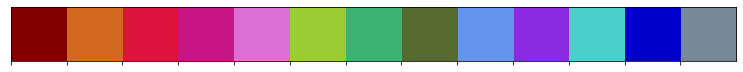

In [24]:
new_pal = [colors[0],colors[3],colors[2],colors[1],colors[9],colors[12],colors[5],colors[4],colors[7],colors[10],colors[6],colors[8],colors[11]]
sns.palplot(sns.color_palette(new_pal))

In [25]:
colors = new_pal

In [26]:
colors

['#800000',
 '#D2691E',
 '#DC143C',
 '#C71585',
 '#DA70D6',
 '#9ACD32',
 '#3CB371',
 '#556B2F',
 '#6495ED',
 '#8A2BE2',
 '#48D1CC',
 '#0000CD',
 '#778899']

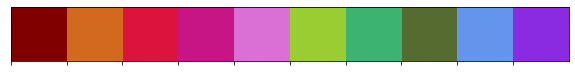

In [27]:
sns.palplot(colors[:10])

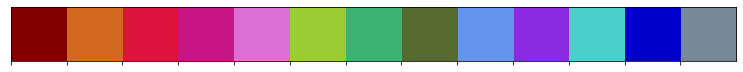

In [28]:
sns.palplot(sns.color_palette(colors))

In [29]:
c_pal = sns.color_palette(colors)

In [30]:
# c_pal = sns.color_palette("tab20", 12)
sns.set_palette(sns.color_palette(colors))


In [31]:
'../../ciona_tierpsy_behavior/Figures/hmm_results/'

'../../ciona_tierpsy_behavior/Figures/hmm_results/'

In [32]:
# save_feb12_folder = '../../ciona_tierpsy_behavior/Figures/hmm_results/'

In [32]:
from pathlib import Path
Path(f'{save_feb12_folder}predict_Seen{n_train_exps}_model{n_states}_{n_feats}feats_results/').mkdir(parents=True, exist_ok=True)

In [33]:
save_folder = f'{save_feb12_folder}predict_Seen{n_train_exps}_model{n_states}_{n_feats}feats_results/'

In [33]:
save_folder = '../../ciona_tierpsy_behavior/Figures/hmm_results/hmm_trajectories_Sep2/'

## Motifs distribution across clusters 

In [ ]:
fig1, axes = plt.subplots(2,2, figsize=(24,16))
axs = axes.flatten()

sns.countplot(data=df_motif_control_151, x='cluster',ax=axs[0])
axs[0].set_title('Motif count in 151 experiments' , y=-0.15, size = 'xx-large')

sns.countplot(data=df_motif_control_543, x='cluster',ax=axs[1])
axs[1].set_title('Motif count in 543 experiments' , y=-0.15, size = 'xx-large')

sns.countplot(data=df_motif_drugs_899, x='cluster',ax=axs[2])
axs[2].set_title('Motif count in all drug experiments' , y=-0.15, size = 'xx-large')

sns.countplot(data=df_motif_light_150, x='cluster',ax=axs[3])
axs[3].set_title('Motif count in all light experiments' , y=-0.15, size = 'xx-large')

plt.suptitle(f'Comparison of number of motifs in clusters  n_states={n_states}',  y= 1.03, size = 'xx-large', weight = 'demibold')
fig1.savefig(f'{save_folder}/countplot_clus{n_states}_{n_train_exps}exps_normed.png')
plt.subplots_adjust(top =0.9, bottom = 0.1, hspace = 0.2, wspace=0.2)
# plt.tight_layout()

In [ ]:
fig2, axes = plt.subplots(2,2, figsize=(16,12), sharey=True)
axs = axes.flatten()


sns.barplot(x="cluster", y= "cluster", data=df_motif_control_151, 
            estimator=lambda x: len(x) / len(df_motif_control_151) * 100, ax=axs[0])
axs[0].set_title('Motif % in 151 experiments' , y=-0.15, size = 'x-large')
axs[0].set_ylabel('percentage')

sns.barplot(x="cluster", y= "cluster", data=df_motif_control_543, 
            estimator=lambda x: len(x) / len(df_motif_control_543) * 100, ax=axs[1])
axs[1].set_title('Motif % in 543 experiments' , y=-0.15, size = 'x-large')
axs[1].set_ylabel('percentage')

sns.barplot(x="cluster", y= "cluster", data=df_motif_drugs_899, 
            estimator=lambda x: len(x) / len(df_motif_drugs_899) * 100, ax=axs[2])
axs[2].set_title('Motif % in all drug experiments' , y=-0.15, size = 'x-large')
axs[2].set_ylabel('percentage')

sns.barplot(x="cluster", y= "cluster", data=df_motif_light_150,
            estimator=lambda x: len(x) / len(df_motif_light_150) * 100, ax=axs[3])
axs[3].set_title('Motif % in all light experiments' , y=-0.15, size = 'x-large')
axs[3].set_ylabel('percentage')

plt.suptitle(f'Comparison of % of motifs in clusters  n_states={n_states}',  y = 1.12, size = 'xx-large', weight = 'demibold')
fig2.savefig(f'{save_folder}/percentplot_clus{n_states}_{n_train_exps}exps_normed.png')
plt.subplots_adjust(top =0.99, bottom = 0.1, hspace = 0.3, wspace=0.2)
# plt.tight_layout()

## Clusters visualized on Paths

In [34]:
widget_dataset = widgets.Dropdown(
    options= ['control_151', 'control_543', 'control_all', 'drugs_899', 'light_150'],
    value= 'control_151',
    description= 'Dataset:',
    disabled=False,
)

In [39]:
data_folder = '/data/longterm/10/athira/Tierpsy_skeleton_files_July13/'

In [49]:
@widgets.interact_manual
def examine_model(dataset = widget_dataset):
    
    if dataset == 'control_151':
        dataset_fns = list(df_motif_control_151['filename'].unique())
        df_motif_grouped_files = df_motif_control_151.groupby('filename')
                           
    elif dataset == 'control_543':
        dataset_fns = list(df_motif_control_543['filename'].unique())
        df_motif_grouped_files = df_motif_control_543.groupby('filename')
                           
    elif dataset == 'drugs_899':
        dataset_fns = list(df_motif_drugs_899['filename'].unique())
        df_motif_grouped_files = df_motif_drugs_899.groupby('filename')
        
    elif dataset == 'light_150':
        dataset_fns = list(df_motif_light_150['filename'].unique())
        df_motif_grouped_files = df_motif_light_150.groupby('filename')
                           
    else:
        dataset_fns = list(df_motif_control_all['filename'].unique())
        df_motif_grouped_files = df_motif_control_all.groupby('filename')
    
    sample_fns = random.sample(dataset_fns, 4)
    print(sample_fns)
#     sample_fns = ['20180808_122216_1_15m0s_None_None_None_skeletons.hdf5', 
#                   '20180725_102308_1_15m0s_None_None_None_skeletons.hdf5',
#                    '20180727_120042_1_5m0s_None_None_None_skeletons.hdf5',
#                     '20180823_100828_1_15m0s_None_None_None_skeletons.hdf5']
# #                   ,
#                     '20180725_150813_1_5m0s_None_None_None_skeletons.hdf5',
#                   '20180823_151523_1_15m0s_None_None_None_skeletons.hdf5']
    
    fig, axes = plt.subplots(2,2, figsize = (50,50), dpi=100, sharex=True, sharey=True)

    axs = axes.flatten()
    for i in range(4):

        fn = sample_fns[i]
        df_exp_motifs = df_motif_grouped_files.get_group(fn)
    #     df_exp_motifs.sort_values(by='start', inplace=True)

        fn_parts = fn.split('_')

        fpath = os.path.join(data_folder, fn)
        skel_obj = h5py.File(fpath, 'r')
        skel_array = np.array(skel_obj['skeleton'])
        skel_array = del_nan_rows(skel_array)


        color_list = np.zeros((skel_array.shape[0],))
        for index, row in df_exp_motifs.iterrows():
            cl = int(row['cluster'])
            for j in range(int(row['start']),int(row['stop'])+1):
                color_list[j] = cl

        color_list1 = [c_pal[int(k)] for k in list(color_list)]
        try:
            axs[i].scatter(skel_array[:,12,0],skel_array[:,12,1], c=color_list1)
        except ValueError:
            print('mismatch number of frames')
        finally:
            axs[i].set_title(f'{fn_parts[0]}_{fn_parts[1]}_{fn_parts[2]}')
            

    fig.savefig(f'{save_folder}/path_4_set3_clus{n_states}_{dataset}.png')

interactive(children=(Dropdown(description='Dataset:', options=('control_151', 'control_543', 'control_all', '…

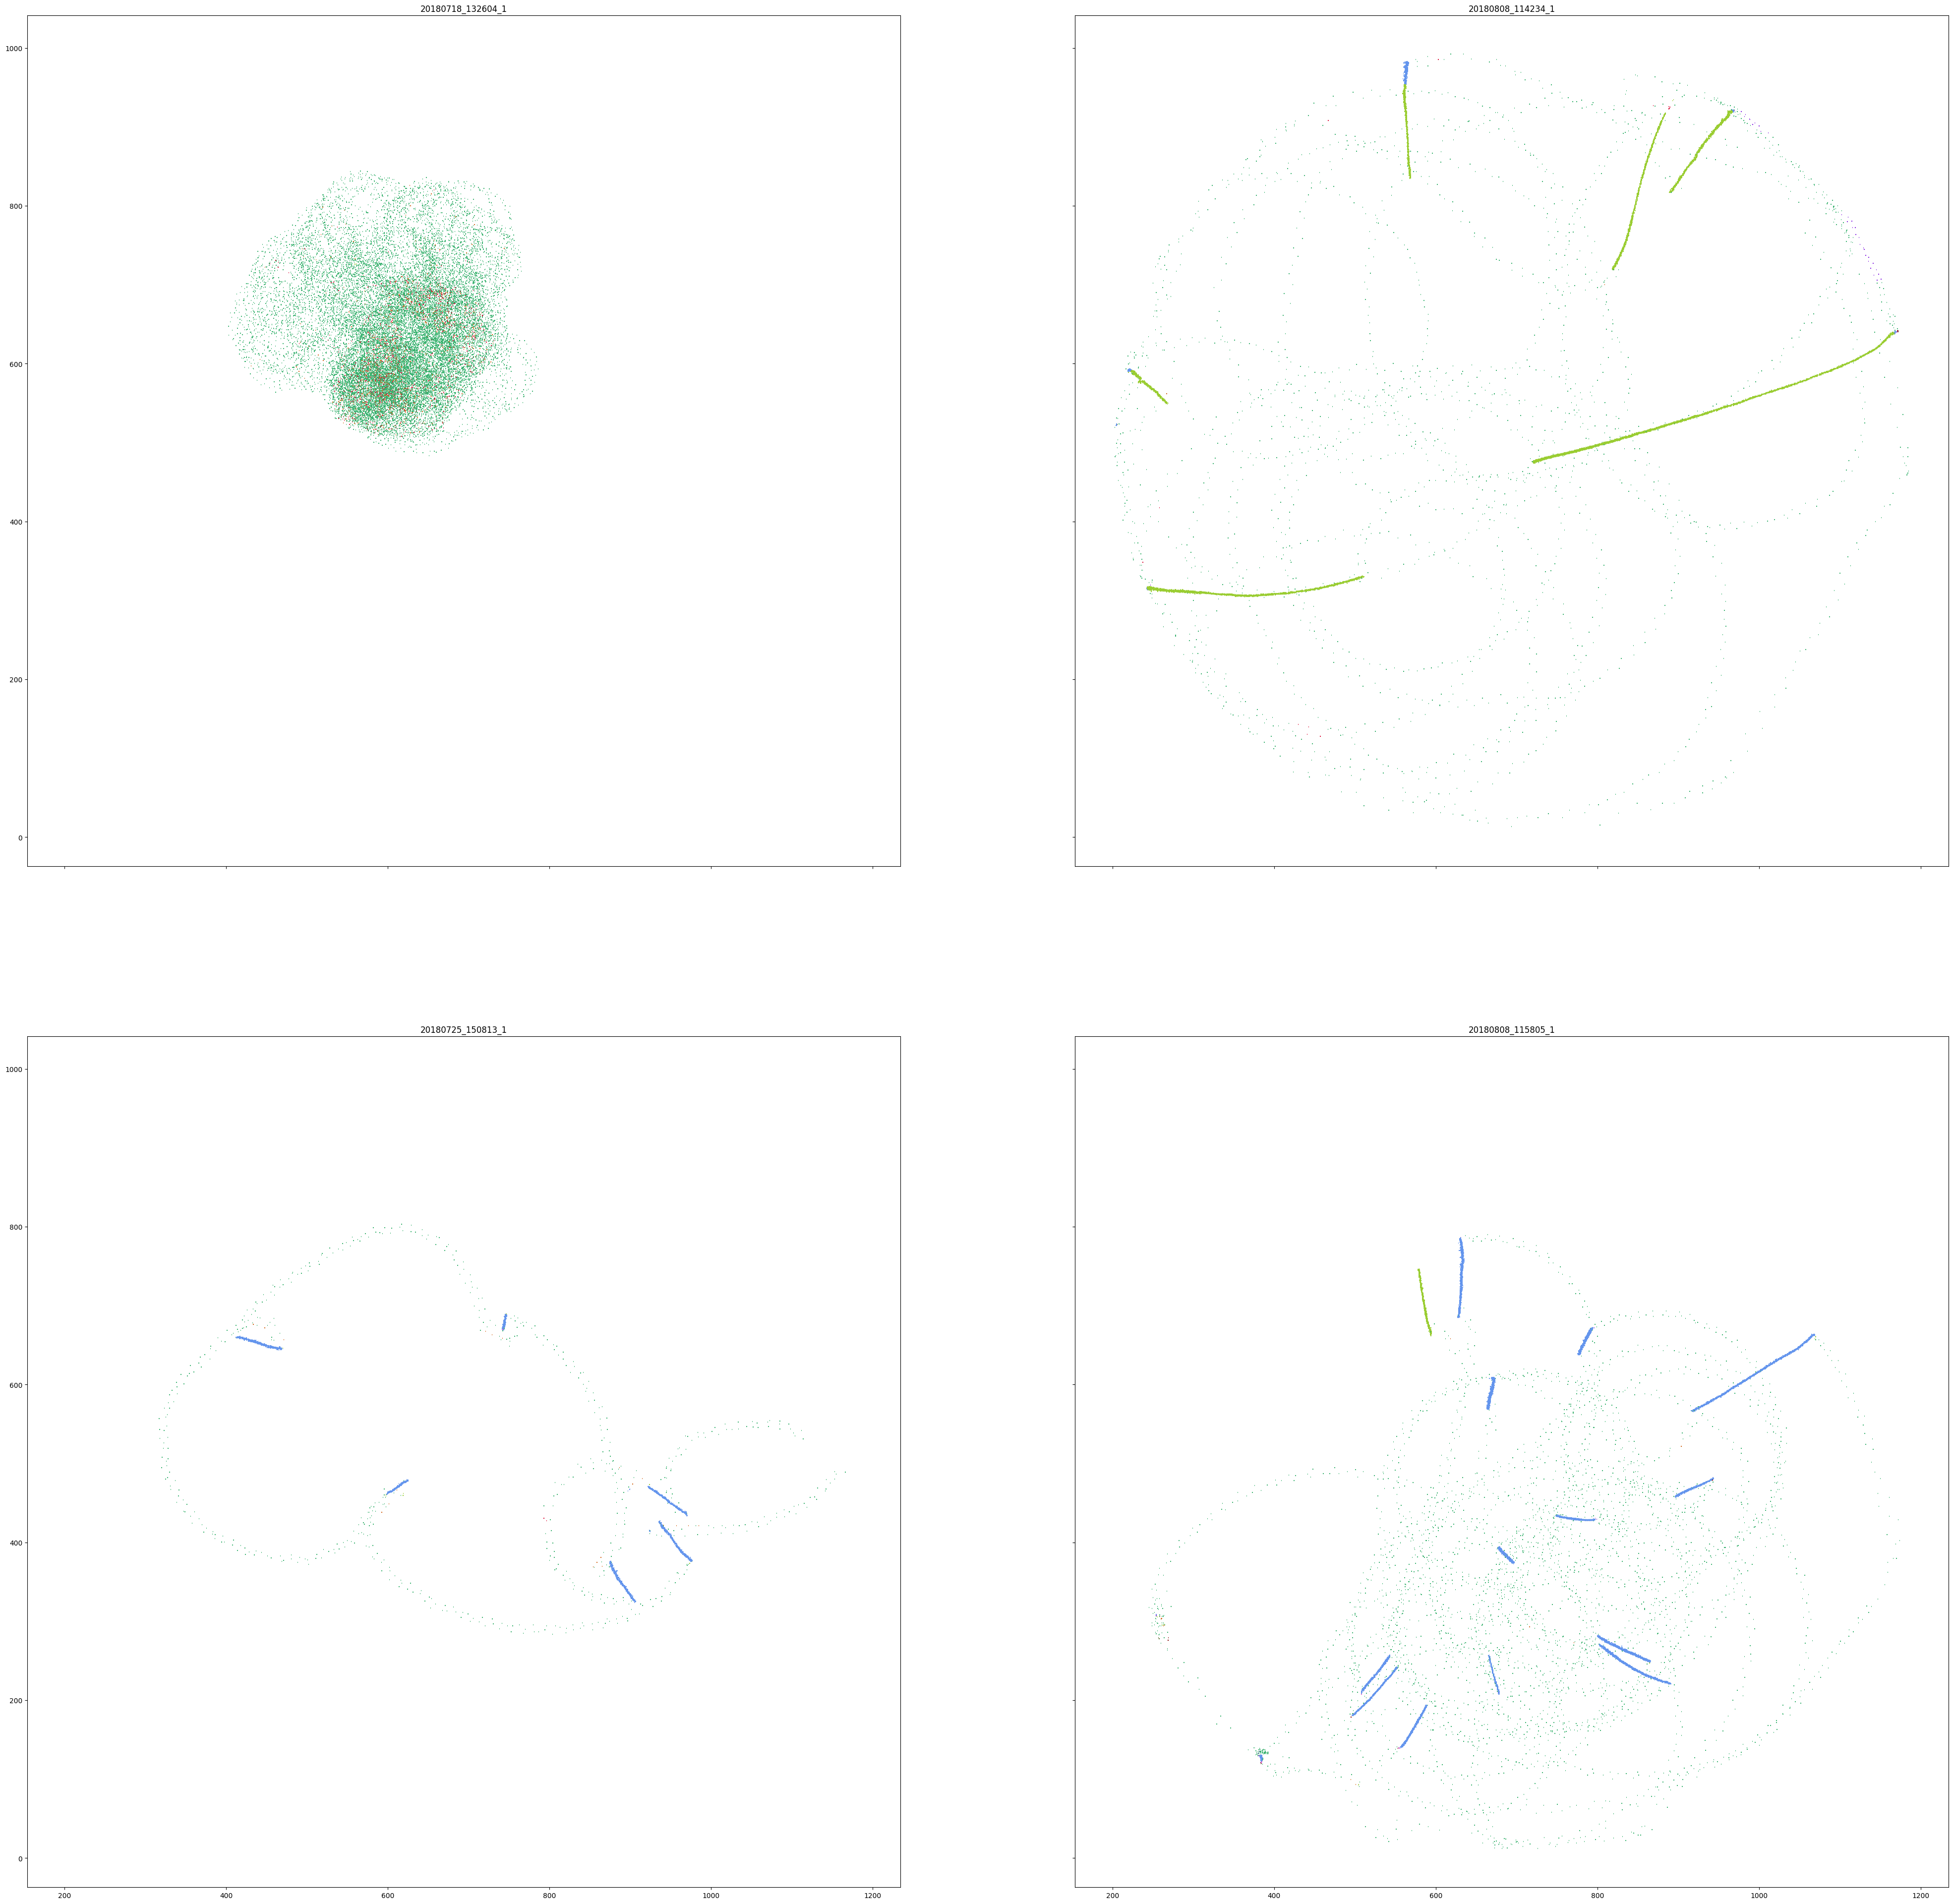

In [47]:

# sample_fns =  ['20180717_112643_1_5m0s_None_None_None_skeletons.hdf5', 
# '20180808_114234_1_15m0s_None_None_None_skeletons.hdf5', 
# '20180725_150813_1_5m0s_None_None_None_skeletons.hdf5', 
# '20180808_115805_1_15m0s_None_None_None_skeletons.hdf5']
sample_fns = ['20180718_132604_1_15m0s_None_None_None_INVERTED_skeletons.hdf5',
             '20180808_114234_1_15m0s_None_None_None_skeletons.hdf5', 
            '20180725_150813_1_5m0s_None_None_None_skeletons.hdf5', 
            '20180808_115805_1_15m0s_None_None_None_skeletons.hdf5']

fig, axes = plt.subplots(2,2, figsize = (50,50), dpi=100, sharex=True, sharey=True)
df_motif_grouped_files = df_motif_control_151.groupby('filename')
axs = axes.flatten()
for i in range(4):

    fn = sample_fns[i]
    df_exp_motifs = df_motif_grouped_files.get_group(fn)
#     df_exp_motifs.sort_values(by='start', inplace=True)

    fn_parts = fn.split('_')

    fpath = os.path.join(data_folder, fn)
    skel_obj = h5py.File(fpath, 'r')
    skel_array = np.array(skel_obj['skeleton'])
    skel_array = del_nan_rows(skel_array)


    color_list = np.zeros((skel_array.shape[0],))
    for index, row in df_exp_motifs.iterrows():
        cl = int(row['cluster'])
        for j in range(int(row['start']),int(row['stop'])+1):
            color_list[j] = cl

    color_list1 = [c_pal[int(k)] for k in list(color_list)]
    try:
        axs[i].scatter(skel_array[:,12,0],skel_array[:,12,1], c=color_list1, s=1, marker ='_')
    except ValueError:
        print('mismatch number of frames')
    finally:
        axs[i].set_title(f'{fn_parts[0]}_{fn_parts[1]}_{fn_parts[2]}')


fig.savefig(f'{save_folder}/path_4_clus3.png')

['20180727_115032_1_5m0s_None_None_None_skeletons.hdf5', '20180716_110053_1_15m0s_None_None_None_INVERTED_skeletons.hdf5', '20180730_112117_1_5m0s_None_None_None_skeletons.hdf5', '20180817_095338_1_5m0s_None_None_None_skeletons.hdf5']

['20180808_122216_1_15m0s_None_None_None_skeletons.hdf5', 
'20180725_102308_1_15m0s_None_None_None_skeletons.hdf5',
'20180727_120042_1_5m0s_None_None_None_skeletons.hdf5',
'20180823_100828_1_15m0s_None_None_None_skeletons.hdf5']

['20180725_150813_1_5m0s_None_None_None_skeletons.hdf5',
'20180823_151523_1_15m0s_None_None_None_skeletons.hdf5',
'20180817_131951_1_5m0s_None_None_None_skeletons.hdf5',
'20180727_170709_1_5m0s_None_None_None_skeletons.hdf5']


                
['20180717_112643_1_5m0s_None_None_None_skeletons.hdf5',
'20180808_114234_1_15m0s_None_None_None_skeletons.hdf5',
'20180725_150813_1_5m0s_None_None_None_skeletons.hdf5',
'20180808_115805_1_15m0s_None_None_None_skeletons.hdf5']                


In [ ]:
# example_fnames_151 = random.sample(list(df_motif_control_151['filename'].unique()), 25)
# len(example_files)

In [ ]:
# df_motif_grouped_files = df_motif_all_151.groupby('filename')

In [ ]:
# sample_fns

In [ ]:
# fig, axes = plt.subplots(5,5, figsize = (50,50), dpi=200, sharex=True, sharey=True)

# axs = axes.flatten()
# for i in range(25):
    
#     fn = example_files[i]
#     df_exp_motifs = df_motif_grouped_files.get_group(fn)
# #     df_exp_motifs.sort_values(by='start', inplace=True)
    
#     fn_parts = fn.split('_')
    
#     fpath = os.path.join(data_folder, fn)
#     skel_obj = h5py.File(fpath, 'r')
#     skel_array = np.array(skel_obj['skeleton'])
#     skel_array = del_nan_rows(skel_array)
    
        
#     color_list = np.zeros((skel_array.shape[0],))
#     for index, row in df_exp_motifs.iterrows():
#         cl = int(row['cluster'])
#         for j in range(int(row['start']),int(row['stop'])+1):
#             color_list[j] = cl
            
#     color_list1 = [c_pal[int(k)] for k in list(color_list)]
#     try:
#         axs[i].scatter(skel_array[:,12,0],skel_array[:,12,1], c=color_list1, s=0.1)
#     except ValueError:
#         print('mismatch number of frames')
#     finally:
#         axs[i].set_title(f'{fn_parts[0]}_{fn_parts[1]}_{fn_parts[2]}')

## Motifs as gifs

In [ ]:
def rotate(x, y, angle):
    xr = x*np.cos(angle) - y* np.sin(angle)
    yr = x*np.sin(angle) + y* np.cos(angle)
    return xr,yr
def get_base_angle(x,y, degrees = False):
    angle = np.arctan(y/x)
    if y < 0:
        angle *=-1
    if not degrees:
        return(angle)
    else:
        return(np.degrees(angle))

In [ ]:
df_motifs_all = pd.concat([df_motif_control_151, df_motif_drugs_899, df_motif_light_150])

In [ ]:
df_motifs_all = df_motif_control_151

In [ ]:
len_frames = 20

In [ ]:
motifs_filter_duration = df_motifs_all[(df_motifs_all['duration'] > len_frames) & (df_motifs_all['duration'] < len_frames+ 50)]
sample_motifs = motifs_filter_duration.groupby(by='cluster').sample(36)
groups = sample_motifs.groupby(by='cluster')

In [ ]:
import matplotlib as mpl

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
mpl.rcParams['animation.embed_limit'] = 2**128

In [ ]:
for cluster in tqdm.tqdm(np.arange(n_states)):
    
    def animate(i):
        for j, m in enumerate(selected_motifs_1):
#             if i%30 == 0:
#                 axes.ravel()[j].clear()
            if i < m.shape[0]:
                frame = m[i,:,:]
                xs = frame[:,0]
                ys = frame[:,1]
#                 angle = get_base_angle(xs[12], ys[12]) - np.pi
#                 xs = xs-frame[12, 0]
#                 ys = ys-frame[12, 1]
#                 xs, ys = rotate(xs, ys, angle)
                axes.ravel()[j].plot(xs, ys, c = c_pal[cluster], alpha = 0.4)
                axes.ravel()[j].axis("off")
#             axes.ravel()[j].set_title(f'{len(m)}')
        plt.suptitle(f'Motifs from Cluster {cluster}')
        
        
    selected_motifs_1 = []
    
#     try:
    motifs = groups.get_group(cluster)

    for i in range(36):
        motif = motifs.iloc[i]

        fname = motif['filename']
        fpath = os.path.join(data_folder, fname)

        skel_obj = h5py.File(fpath, 'r')
        skel_array = np.array(skel_obj['skeleton'])
        skel_array = del_nan_rows(skel_array)

        start = int(motif['start'])
        stop = int(motif['stop'])

        selected_motifs_1.append(skel_array[start:stop,:,:])
    print(len(selected_motifs_1))
    fig, axes = plt.subplots(6,6, figsize = (10,10))

    
    from pathlib import Path
    Path(f'{save_folder}/unaligned_gifs/').mkdir(parents=True, exist_ok=True)

    anim = animation(fig, animate, frames = len_frames +100, interval = 200).save(f'{save_folder}/unaligned_gifs/clus{cluster}_hmm.gif', writer='imagemagick')
    

    fig.savefig(f'{save_folder}/aligned_gifs/hmm_motif_unaligned_cl{cluster}_many.png')
#     except Exception as e:
#         print("Oops!", e.__class__, "occurred.")

### Extras

In [ ]:
for cluster in tqdm.tqdm(np.arange(n_states)):
    
    def animate(i):
        for j, m in enumerate(selected_motifs_1):
#             if i%30 == 0:
#                 axes.ravel()[j].clear()
            frame = m[i,:,:]
            xs = frame[:,0]
            ys = frame[:,1]
            angle = get_base_angle(xs[12], ys[12]) - np.pi
            xs = xs-frame[12, 0]
            ys = ys-frame[12, 1]
            xs, ys = rotate(xs, ys, angle)
            axes.ravel()[j].plot(xs, ys, c = c_pal[cluster], alpha = 0.4)
            axes.ravel()[j].axis("off")
#             axes.ravel()[j].set_title(f'{len(m)}')
        plt.suptitle(f'Motifs from Cluster {cluster}')
        
        
    selected_motifs_1 = []
    
    try:
        motifs = groups.get_group(cluster)

        for i in range(25):
            motif = motifs.iloc[i]

            fname = motif['filename']
            fpath = os.path.join(data_folder, fname)

            skel_obj = h5py.File(fpath, 'r')
            skel_array = np.array(skel_obj['skeleton'])
            skel_array = del_nan_rows(skel_array)

            start = int(motif['start'])
            stop = int(motif['stop'])

            selected_motifs_1.append(skel_array[start:stop,:,:])

        fig, axes = plt.subplots(5,5, figsize = (10,10))

        anim = animation(fig, animate, frames = 15, interval = 200).save(f'../Results/predict_Seen1743_model12_results/aligned_gifs_Seen694_model8normed694_tryabove30/new_clus{cluster}.gif', writer='imagemagick')


In [ ]:
@widgets.interact_manual
def animate_cluster(cluster=range(n_states)):
    
    def animate(i):
        for j, m in enumerate(selected_motifs_1):
#             if i%30 == 0:
#                 axes.ravel()[j].clear()
            frame = m[i,:,:]
            xs = frame[:,0]
            ys = frame[:,1]
            angle = get_base_angle(xs[12], ys[12]) - np.pi
            xs = xs-frame[12, 0]
            ys = ys-frame[12, 1]
            xs, ys = rotate(xs, ys, angle)
            axes.ravel()[j].plot(xs, ys, c = c_pal[cluster], alpha = 0.4)
            axes.ravel()[j].axis("off")
#             axes.ravel()[j].set_title(f'{len(m)}')
        plt.suptitle(f'Motifs from Cluster {cluster}')
        
        
    selected_motifs_1 = []
    motifs = groups.get_group(cluster)

    for i in range(25):
        motif = motifs.iloc[i]

        fname = motif['filename']
        fpath = os.path.join(data_folder, fname)

        skel_obj = h5py.File(fpath, 'r')
        skel_array = np.array(skel_obj['skeleton'])
        skel_array = del_nan_rows(skel_array)

        start = int(motif['start'])
        stop = int(motif['stop'])

        selected_motifs_1.append(skel_array[start:stop,:,:])
        
    fig, axes = plt.subplots(5,5, figsize = (10,10))
    
    anim = animation(fig, animate, frames = 15, interval = 200).save(f'../Results/predict_testControlSeen_model694_results/unaligned_gifs_testControlSeen_model694_/new_clus{cluster}.gif', writer='imagemagick')
#     display(HTML(anim))

In [ ]:
@widgets.interact_manual
def animate_cluster(cluster=range(n_states)):
    
    def animate(i):
        
        
        for j, m in enumerate(selected_motifs_2):
            try:
                frame = m[i,:,:]
                xs = frame[:,0]
                ys = frame[:,1]
        #             angle = get_base_angle(xs[12], ys[12]) - np.pi
        #             xs = xs-frame[12, 0]
        #             ys = ys-frame[12, 1]
        #             xs, ys = rotate(xs, ys, angle)
                axes.ravel()[j].plot(xs, ys, c = c_pal[cluster], alpha = 0.4)
            
            except IndexError:
                pass
            finally:
                axes.ravel()[j].axis("off")
                axes.ravel()[j].set_title(f'dur {len(m)}')
        
        plt.suptitle(f'Motifs from Cluster {cluster}')
        
    selected_motifs_2 = []
    motifs = groups.get_group(cluster)

    for i in range(15):
        motif = motifs.iloc[i]

        fname = motif['filename']
        fpath = os.path.join(data_folder, fname)

        skel_obj = h5py.File(fpath, 'r')
        skel_array = np.array(skel_obj['skeleton'])
        skel_array = del_nan_rows(skel_array)

        start = int(motif['start'])
        stop = int(motif['stop'])

        selected_motifs_2.append(skel_array[start:stop,:,:])
        
    fig, axes = plt.subplots(2,15, figsize = (30,6))
    for k in range(15,30):
        axes.ravel()[k].scatter(selected_motifs_2[k-15][:,:,0],selected_motifs_2[k-15][:,:,1], s=0.1)
        axes.ravel()[k].axis('off')
    anim = animation(fig, animate, frames = 15, interval = 100).to_jshtml()#.save(f'../Results/aligned_gifs_testControlUnseen543/clus{cluster}.gif', writer='imagemagick')
    display(HTML(anim))

# Align motifs on vertical axis 

In [ ]:
def translate(skel_coords, neck_ind):
    
    diff = skel_coords[neck_ind]
    skel_coords_trans = skel_coords - diff
    
    return skel_coords_trans

In [ ]:
def angle(x,y, degrees = False):
    angle = np.arctan2(y,x)
#     if y < 0:
#         angle *=-1
    if not degrees:
        return(angle)
    else:
        return(np.degrees(angle))

In [ ]:
def rotate_matrix(skel_array,angle):
    xr = skel_array[:,0]*np.cos(angle) - skel_array[:,1]* np.sin(angle)
    yr = skel_array[:,0]*np.sin(angle) + skel_array[:,1]* np.cos(angle)
    return xr,yr

In [ ]:
def rotate(x, y, angle):
    xr = x*np.cos(angle) - y* np.sin(angle)
    yr = x*np.sin(angle) + y* np.cos(angle)
    return xr,yr

In [ ]:
df_motifs_all = pd.concat([df_motif_control_151, df_motif_control_543, df_motif_drugs_899])

In [ ]:
dur = 300
motifs_8 = df_motifs_all[(df_motifs_all['duration'] <= dur) & ((df_motifs_all['duration'] > 14))]
sample_motifs_8 = motifs_8.groupby(by='cluster').sample(5)
groups = sample_motifs_8.groupby(by='cluster')

In [ ]:
motifs_list = []
for i in range(n_states):
        
    motif = groups.get_group(i)
    motifs_list.append(motif)

motifs = pd.concat(motifs_list)

In [ ]:

fig, axes = plt.subplots(2,5,figsize=(25,15), sharey=True)

axs = axes.ravel()

for i in range(len(motifs.index)):
    
    motif = motifs.iloc[i]

    fname = motif['filename']
    fpath = os.path.join(data_folder, fname)

    skel_obj = h5py.File(fpath, 'r')
    skel_array = np.array(skel_obj['skeleton'])
    skel_array = del_nan_rows(skel_array)

    start = int(motif['start'])
    stop = int(motif['stop'])

    motif_skels = skel_array[start:stop,:,:]
        
    cluster = int(motif['cluster'])
    
    for j, ind in enumerate(range(start, stop)):

        neck_ind = 12

        c_n = c_pal[cluster]
        
        skel_coords = motif_skels[j,:,:]

#         axes[0][i].plot(skel_coords[:,0],skel_coords[:,1], color=c_n)
#         axes[0][i].scatter(skel_coords[neck_ind,0],skel_coords[neck_ind,1])
#         axes[0][i].axis('equal')

        # Let us move the neck to the origin
        skel_coords_trans = translate(skel_coords,neck_ind)
#         axes[1][i].plot(skel_coords_trans[:,0],skel_coords_trans[:,1], color=c_n)
#         axes[1][i].scatter(skel_coords_trans[neck_ind,0],skel_coords_trans[neck_ind,1])
#         axes[1][i].axis('equal')
#         axes[1][i].axvline(x=0, ls=':')

        # Find the angle by which the tail tip has to be rotated for it to fall on the vertical line through origin
        rot_angle = angle(skel_coords_trans[-1,0],skel_coords_trans[-1,1], degrees = False)
    #         print(np.rad2deg(rot_angle))

        #rotate all the points in the skeleton
        if rot_angle > np.pi/2:
            rotation = 3*(np.pi/2)-rot_angle
#         elif rot_angle < (-1*np.pi/2):
#             rotation = -(np.pi/2+rot_angle)
#         elif ((rot_angle > 0) & (rot_angle <= np.pi/2)):
#             rotation = (np.pi/2+rot_angle)
        else:
            rotation = -(np.pi/2+rot_angle)



        xr,yr = rotate_matrix(skel_coords_trans, rotation)
#         axes[2][i].plot(xr,yr, color = c_n)
#         axes[2][i].scatter(xr[neck_ind],yr[neck_ind])
#         axes[2][i].axis('equal')
#         axes[2][i].axis('off')
#         axes[2][i].axvline(x=0, ls=':',c='k',linewidth=1)
 
        axs[cluster].plot(xr,yr, color = c_n, alpha = 0.3)
        axs[cluster].scatter(xr[neck_ind],yr[neck_ind], color = c_n)
        axs[cluster].axis('equal')
        axs[cluster].axis('off')
        axs[cluster].set_title(f'State {cluster}', size = 'x-large')
        axs[cluster].axvline(x=0, ls=':',c='k',linewidth=1)
        
for ax in axs:
    ax.axis('off')
        
fig.savefig(f'{save_folder}/panel_b/skeletons_vertical_8.svg')

# Animation + Path

In [ ]:
df_motifs_all = pd.concat([df_motif_control_151, df_motif_control_543, df_motif_drugs_899])

In [ ]:
dataset_fns = list(df_motif_control_151['filename'].unique())
df_motif_grouped_files = df_motif_control_151.groupby('filename')

In [ ]:
dataset_fns = sorted(dataset_fns)

In [ ]:
widget_exp = widgets.Dropdown(
    options= dataset_fns,
    value= dataset_fns[0],
    description= 'Experiment:',
    disabled=False,
)

In [ ]:
@widgets.interact_manual
def select_exp(fn = widget_exp):
    
    return fn       

In [ ]:
fpath = os.path.join(data_folder, widget_exp.value)

skel_obj = h5py.File(fpath, 'r')
skel_array = np.array(skel_obj['skeleton'])
skel_array = del_nan_rows(skel_array)
skel_array.shape

In [ ]:

def animate_path_and_skel(fname = widget_exp.value):
    
    def animate(i):
        
        
        
        try:
            frame = motif[i,:,:]
            xs = frame[:,0]
            ys = frame[:,1]
            
            axes[0].plot(frame[12,0],frame[12,1], c = c_pal[int(color_list[i])], 
                         marker='o', linestyle='dashed', linewidth=2, markersize=12)
            axes[1].plot(xs, ys, c = c_pal[int(color_list[i])], alpha = 0.4)
            
            angle = get_base_angle(xs[12], ys[12]) - np.pi
            xs = xs-frame[12, 0]
            ys = ys-frame[12, 1]
            xs, ys = rotate(xs, ys, angle)
            
            axes[2].plot(xs, ys, c = c_pal[int(color_list[i])], alpha = 0.4)
            
        except IndexError:
            pass
        finally:
            axes[1].axis("off")
            axes[2].axis("off")

        

    fpath = os.path.join(data_folder, fname)

    skel_obj = h5py.File(fpath, 'r')
    skel_array = np.array(skel_obj['skeleton'])
    skel_array = del_nan_rows(skel_array)

    color_list = np.zeros((skel_array.shape[0],))
    
    df_exp_motifs = df_motif_grouped_files.get_group(fname)
    for index, row in df_exp_motifs.iterrows():
        cl = int(row['cluster'])
        for j in range(int(row['start']),int(row['stop'])+1):
            color_list[j] = cl
        
    fig, axes = plt.subplots(1,3, figsize = (25,10))
    
    motif = skel_array
    
    xmin = np.amin(skel_array[:, :, 0]) - 5
    xmax = np.amax(skel_array[:, :, 0]) + 5
    ymin = np.amin(skel_array[:, :, 1]) - 5
    ymax = np.amax(skel_array[:, :, 1]) + 5
    
    for ax in [axes[0],axes[1]]:
        ax.set_xlim([xmin,xmax])
        ax.set_ylim([ymin,ymax])
    
    
    anim = animation(fig, animate, frames = range(2087,2387) , interval = 100).save(f'/share/data/temp/athira/path_anim.gif', writer='imagemagick')#.to_jshtml()
#     display(HTML(anim))

In [ ]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 50

In [ ]:
animate_path_and_skel()

In [ ]:
widget_window = widgets.IntRangeSlider(
    value=[0, 200],
    min=0,
    max= skel_array.shape[0]-1,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

In [ ]:
@widgets.interact_manual
def draw_path_and_skel(time_window = widget_window):
    
    
    
    def animate(i):
        
        try:
            frame = motif[i,:,:]
            xs = frame[:,0]
            ys = frame[:,1]
            
            axes[0].plot(frame[12,0],frame[12,1], c = c_pal[int(color_list[i])], 
                         marker='o', linestyle='dashed', linewidth=2, markersize= 1)
            axes[1].plot(xs, ys, c = c_pal[int(color_list[i])], alpha = 0.4)
            
        except IndexError:
            pass
#         finally:
#             axes[1].axis("off")

    fname = widget_exp.value    

    fpath = os.path.join(data_folder, fname)

    skel_obj = h5py.File(fpath, 'r')
    skel_array = np.array(skel_obj['skeleton'])
    skel_array = del_nan_rows(skel_array)

    color_list = np.zeros((skel_array.shape[0],))
    
    df_exp_motifs = df_motif_grouped_files.get_group(fname)
    for index, row in df_exp_motifs.iterrows():
        cl = int(row['cluster'])
        for j in range(int(row['start']),int(row['stop'])+1):
            color_list[j] = cl
        
    fig, axes = plt.subplots(1,2, figsize = (20,10))
    
    motif = skel_array
    
    xmin = np.amin(skel_array[:, :, 0]) -5
    xmax = np.amax(skel_array[:, :, 0]) +5
    ymin = np.amin(skel_array[:, :, 1]) -5
    ymax = np.amax(skel_array[:, :, 1]) +5
    
    for ax in axes:
        ax.set_xlim([xmin,xmax])
        ax.set_ylim([ymin,ymax])
        
    start = time_window[0]
    stop = time_window[1]
    
    for i in range(start, stop):
        animate(i)

#     axes[0].plot(skel_array[start:stop,12,0],skel_array[start:stop,12,1], c = c_pal[int(color_list[i])], 
#                  marker='o', linestyle='dashed', linewidth=2, markersize=12)
#     axes[1].plot(skel_array[start:stop,:,0], skel_array[start:stop,:,0], c = c_pal[int(color_list[i])], alpha = 0.4)
    

# Transitions of transitions

In [ ]:
n_states

In [69]:
def make_binarycluster_df(df):    
    
    data = df.filter(items = feats_list).values
    
    clusters = model.predict(data)
    
    fname = df.filename.unique()[0]
    fpath = os.path.join(data_folder, fname)
    
#     clus_dict = {}
#     clus_dict['cluser'] = clusters
#     clus_dict['filename'] = fname 
#     clus_dict['drug'] = fname.split('_')[4] 
#     clus_dict['light'] = fname.split('_')[6]
    
#     df_cluster = pd.DataFrame(clus_dict) 
    
#     return df_cluster

    return list(clusters)

## Control data

In [ ]:
list_clusters_all = Parallel(n_jobs=20, verbose = 5)(delayed(make_binarycluster_df)(df) 
                                                for df in df_exps)

In [ ]:
drug_chosen = 'None'

## Drug data

In [ ]:
drug_list = df_features_drugs_qual.drug.unique()

In [ ]:
widget_drug = widgets.Dropdown(
    options= drug_list,
    value= drug_list[0],
    description= 'scaler:',
    disabled=False,
)

In [ ]:
@widgets.interact_manual
def examine_model(drug_chosen = widget_drug):
    
    return drug_chosen

In [ ]:
drug_chosen = widget_drug.value
drug_chosen

In [ ]:
df_drug = df_features_drugs_qual[df_features_drugs_qual['drug'] == drug_chosen]

In [ ]:
df_drug

In [ ]:
df_drugs_qual_files = df_drug.groupby(by = 'filename')

In [ ]:
df_drug_qual_exps = []
for fname in list(df_drug.filename.unique()):
    df_drug_qual_exps.append(df_drugs_qual_files.get_group(fname))
len(df_drug_qual_exps)

In [ ]:
list_clusters_all = Parallel(n_jobs=20, verbose = 5)(delayed(make_binarycluster_df)(df) 
                                                for df in df_drug_qual_exps)
# df_motif_all = pd.concat(list_df_clusters_all)
# fn_motif_all = f'../Data/clusters_dataframe_{n_train_exps}{all_seen}Control694_{n_states}model{fn_motif_tail}.pkl'

In [ ]:
list_dfs = []

for list_clus in list_clusters_all:
    
    start_list = [x for x in list_clus[:-1]]
    stop_list = [x for x in list_clus[1:]]
    
    trans_dict = {'start': start_list, 'stop': stop_list}
    df = pd.DataFrame(trans_dict)
    list_dfs.append(df)
transition_df = pd.concat(list_dfs)   

In [ ]:
transition_counts_control = transition_df.groupby(['start', 'stop']).size().reset_index(name='counts')

In [ ]:
trans_mat_counts = pd.pivot_table(transition_counts_control, values='counts', index=['start'],
                    columns=['stop'])

In [ ]:
trans_mat_counts = trans_mat_counts.fillna(0)

In [ ]:
trans_mat_probs = trans_mat_counts.div(trans_mat_counts.sum(axis=1))

In [ ]:
trans_mat_probs

In [ ]:
for drug_chosen in tqdm.tqdm(drug_list):
    
    df_drug = df_features_drugs_qual[df_features_drugs_qual['drug'] == drug_chosen]
    df_drugs_qual_files = df_drug.groupby(by = 'filename')
    
    df_drug_qual_exps = []
    for fname in list(df_drug.filename.unique()):
        df_drug_qual_exps.append(df_drugs_qual_files.get_group(fname))
        
    list_clusters_all = Parallel(n_jobs=20, verbose = 5)(delayed(make_binarycluster_df)(df) 
                                                for df in df_drug_qual_exps)
    
    
    list_dfs = []
    for list_clus in list_clusters_all:

        start_list = [x for x in list_clus[:-1]]
        stop_list = [x for x in list_clus[1:]]

        trans_dict = {'start': start_list, 'stop': stop_list}
        df = pd.DataFrame(trans_dict)
        list_dfs.append(df)
    transition_df = pd.concat(list_dfs) 
    
    transition_counts_control = transition_df.groupby(['start', 'stop']).size().reset_index(name='counts')
    trans_mat_counts = pd.pivot_table(transition_counts_control, values='counts', index=['start'],
                    columns=['stop'])
    trans_mat_counts = trans_mat_counts.fillna(0)
    trans_mat_probs = trans_mat_counts.div(trans_mat_counts.sum(axis=1))
    trans_mat_probs.to_pickle(f'../Data/transmat_{n_states}states_feats{n_feats}/transmat_{drug_chosen}drug{len(df_drug_qual_exps)}_{n_states}states_{n_feats}feats.pkl')

In [ ]:
# trans_mat_probs.to_pickle(f'../Data/transmat_{drug_chosen}drug{len(df_exps)}_{n_states}states_{n_feats}feats.pkl')

In [ ]:
trans_mat_probs.to_pickle(f'../Data/transmat_{n_states}states_feats{n_feats}/transmat_{drug_chosen}drug{len(df_exps)}_{n_states}states_{n_feats}feats.pkl')

In [ ]:
pd.__version__

In [ ]:
# cluster_control_lens = [len(x) for x in list_clusters_all]
# len(cluster_control_lens)

In [ ]:
# X_train_control = []

In [ ]:
# for i in range(len(cluster_control_lens)):
#     X_train_control.extend(list_clusters_all[i])
# print(len(X_train_control),np.sum(cluster_control_lens))

In [ ]:
# np.shape(X_train_control)

In [ ]:
# # X_train_control = np.array(X_train_control)
# # cluster_control_lens = np.array(cluster_control_lens)

# X_train_control = np.reshape(X_train_control,(-1,1))
# # cluster_control_lens = np.reshape(cluster_control_lens,(-1,1))

# print(X_train_control.shape, np.shape(cluster_control_lens))

## Light data

In [65]:
stim_name_list = df_features_light_qual.stimuli_name.unique()
stim_stat_list = df_features_light_qual.stim_stat.unique()

In [67]:
print(stim_name_list,stim_stat_list)


['blue' 'red' 'green' 'white'] ['None' 'tONbefore' 'tONafter' 'tOFFbefore' 'tOFFafter']


In [75]:
f'transmat_{n_states}states_feats{n_feats}_light'

'transmat_10states_feats7_light'

In [77]:
df_features_light_qual.drug.unique()

array(['AA', 'None', 'Dopamine', 'Fluoxetine', 'Serotonin'], dtype=object)

In [127]:
for stim_name in tqdm.tqdm(stim_name_list):
    for stim_stat in tqdm.tqdm(stim_stat_list):
        
        df_light = df_features_light_qual[(df_features_light_qual['stim_stat'] == stim_stat)
                                           &(df_features_light_qual['stimuli_name'] == stim_name)
                                         &(df_features_light_qual['drug'] == 'None')]
        df_lights_qual_files = df_light.groupby(by = 'filename')

        df_light_qual_exps = []
        for fname in list(df_light.filename.unique()):
            df_light_qual_exps.append(df_light_qual_files.get_group(fname))

        list_clusters_all = Parallel(n_jobs=20, verbose = 5)(delayed(make_binarycluster_df)(df) 
                                                    for df in df_light_qual_exps)


        list_dfs = []
        for list_clus in list_clusters_all:

            start_list = [x for x in list_clus[:-1]]
            stop_list = [x for x in list_clus[1:]]

            trans_dict = {'start': start_list, 'stop': stop_list}
            df = pd.DataFrame(trans_dict)
            list_dfs.append(df)
        transition_df = pd.concat(list_dfs) 

        transition_counts_control = transition_df.groupby(['start', 'stop']).size().reset_index(name='counts')
        trans_mat_counts = pd.pivot_table(transition_counts_control, values='counts', index=['start'],
                        columns=['stop'])
        trans_mat_counts = trans_mat_counts.fillna(0)
        trans_mat_probs = trans_mat_counts.div(trans_mat_counts.sum(axis=1))
        
        display(trans_mat_probs)
        trans_mat_probs.to_pickle(f'../Data/transmat_{n_states}states_feats{n_feats}_light1/transmat_{stim_stat}_{stim_name}_light{len(df_light_qual_exps)}_{n_states}states_{n_feats}feats.pkl')

  0%|          | 0/5 [00:00<?, ?it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   4 out of  23 | elapsed:    1.7s remaining:    7.9s
[Parallel(n_jobs=20)]: Done   9 out of  23 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=20)]: Done  14 out of  23 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=20)]: Done  19 out of  23 | elapsed:    1.7s remaining:    0.4s
[Parallel(n_jobs=20)]: Done  23 out of  23 | elapsed:    1.8s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.997079,0.000235,0.000000,0.000000,0.000358,0.000000,0.000541,0.000261,0.000000,0.000355
1,0.000000,0.786278,0.039168,0.000341,0.000000,0.007660,0.067015,0.000000,0.000000,0.000497
2,0.000000,0.034836,0.924500,0.004258,0.000000,0.006339,0.007261,0.000392,0.000185,0.001705
3,0.000000,0.000942,0.007158,0.992336,0.000000,0.000000,0.000361,0.001698,0.000000,0.000568
4,0.000209,0.000118,0.000135,0.000000,0.998468,0.000000,0.000271,0.000000,0.000370,0.001279
5,0.000000,0.002589,0.003241,0.000170,0.000000,0.974379,0.000271,0.000000,0.003144,0.001848
6,0.000209,0.173355,0.020800,0.000766,0.000102,0.001321,0.921936,0.004965,0.001295,0.002913
7,0.001669,0.000235,0.000540,0.001873,0.000000,0.000000,0.000857,0.989809,0.000000,0.001066
8,0.000000,0.000471,0.000135,0.000000,0.000204,0.003434,0.000180,0.000000,0.992787,0.000924



 20%|██        | 1/5 [00:02<00:08,  2.07s/it][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  21 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=20)]: Done   7 out of  21 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  12 out of  21 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  17 out of  21 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  21 out of  21 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.997079,0.000236,0.000000,0.000000,0.000358,0.000000,0.000555,0.000261,0.000000,0.000355
1,0.000000,0.786926,0.039189,0.000341,0.000000,0.007796,0.068387,0.000000,0.000000,0.000498
2,0.000000,0.034865,0.924595,0.004258,0.000000,0.006452,0.007444,0.000392,0.000193,0.001635
3,0.000000,0.000942,0.007162,0.992336,0.000000,0.000000,0.000370,0.001698,0.000000,0.000569
4,0.000209,0.000118,0.000135,0.000000,0.998468,0.000000,0.000277,0.000000,0.000386,0.001279
5,0.000000,0.002591,0.003243,0.000170,0.000000,0.974462,0.000231,0.000000,0.003089,0.001848
6,0.000209,0.172674,0.020676,0.000766,0.000102,0.001075,0.920377,0.004965,0.001352,0.002914
7,0.001669,0.000236,0.000541,0.001873,0.000000,0.000000,0.000879,0.989809,0.000000,0.001066
8,0.000000,0.000471,0.000135,0.000000,0.000204,0.003495,0.000185,0.000000,0.992470,0.000924



 40%|████      | 2/5 [00:02<00:04,  1.57s/it][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  21 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=20)]: Done   7 out of  21 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  12 out of  21 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  17 out of  21 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  21 out of  21 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.997079,0.000236,0.000000,0.000000,0.000358,0.000000,0.000555,0.000261,0.000000,0.000355
1,0.000000,0.786926,0.039189,0.000341,0.000000,0.007796,0.068387,0.000000,0.000000,0.000498
2,0.000000,0.034865,0.924595,0.004258,0.000000,0.006452,0.007444,0.000392,0.000193,0.001635
3,0.000000,0.000942,0.007162,0.992336,0.000000,0.000000,0.000370,0.001698,0.000000,0.000569
4,0.000209,0.000118,0.000135,0.000000,0.998468,0.000000,0.000277,0.000000,0.000386,0.001279
5,0.000000,0.002591,0.003243,0.000170,0.000000,0.974462,0.000231,0.000000,0.003089,0.001848
6,0.000209,0.172674,0.020676,0.000766,0.000102,0.001075,0.920377,0.004965,0.001352,0.002914
7,0.001669,0.000236,0.000541,0.001873,0.000000,0.000000,0.000879,0.989809,0.000000,0.001066
8,0.000000,0.000471,0.000135,0.000000,0.000204,0.003495,0.000185,0.000000,0.992470,0.000924



 60%|██████    | 3/5 [00:02<00:02,  1.23s/it][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=20)]: Done   7 out of  18 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  11 out of  18 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  15 out of  18 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  18 out of  18 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.996517,0.000281,0.000000,0.000000,0.000358,0.000000,0.000516,0.000261,0.000000,0.000288
1,0.000000,0.751898,0.037595,0.000341,0.000000,0.008494,0.068104,0.000000,0.000000,0.000504
2,0.000000,0.039218,0.925363,0.004261,0.000000,0.007030,0.007499,0.000392,0.000230,0.001657
3,0.000000,0.001125,0.007326,0.992331,0.000000,0.000000,0.000375,0.001698,0.000000,0.000576
4,0.000268,0.000141,0.000138,0.000000,0.998468,0.000000,0.000281,0.000000,0.000461,0.001297
5,0.000000,0.003092,0.003317,0.000170,0.000000,0.972466,0.000234,0.000000,0.003457,0.001873
6,0.000268,0.202418,0.021009,0.000682,0.000102,0.001172,0.920600,0.004965,0.001613,0.002954
7,0.002144,0.000281,0.000553,0.001875,0.000000,0.000000,0.000891,0.989809,0.000000,0.001081
8,0.000000,0.000562,0.000138,0.000000,0.000204,0.003515,0.000187,0.000000,0.991703,0.000792



 80%|████████  | 4/5 [00:03<00:00,  1.00it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   5 out of  16 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=20)]: Done   9 out of  16 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  13 out of  16 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  16 out of  16 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.994587,0.000281,0.000000,0.000000,0.000358,0.000000,0.000516,0.000261,0.000000,0.000298
1,0.000000,0.751898,0.037989,0.000341,0.000000,0.008494,0.068104,0.000000,0.000000,0.000521
2,0.000000,0.039218,0.925140,0.004261,0.000000,0.007030,0.007499,0.000392,0.000428,0.001414
3,0.000000,0.001125,0.007402,0.992331,0.000000,0.000000,0.000375,0.001698,0.000000,0.000595
4,0.000416,0.000141,0.000140,0.000000,0.998468,0.000000,0.000281,0.000000,0.000856,0.001340
5,0.000000,0.003092,0.003352,0.000170,0.000000,0.972466,0.000234,0.000000,0.006421,0.001935
6,0.000416,0.202418,0.021229,0.000682,0.000102,0.001172,0.920600,0.004965,0.002997,0.003051
7,0.003331,0.000281,0.000559,0.001875,0.000000,0.000000,0.000891,0.989809,0.000000,0.001116
8,0.000000,0.000562,0.000140,0.000000,0.000204,0.003515,0.000187,0.000000,0.986301,0.000521



  0%|          | 0/5 [00:00<?, ?it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   6 out of  27 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  12 out of  27 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  18 out of  27 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  24 out of  27 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  27 out of  27 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.994802,0.000132,0.000110,0.000000,0.002543,0.000000,0.002347,0.000719,0.000208,0.001481
1,0.000000,0.944011,0.022344,0.000000,0.000000,0.004852,0.029577,0.000000,0.000000,0.000135
2,0.000047,0.015137,0.931216,0.000000,0.000098,0.010243,0.009533,0.000080,0.000104,0.008346
3,0.000000,0.000132,0.000110,0.997809,0.000000,0.000000,0.000440,0.000400,0.000000,0.000067
4,0.001040,0.000198,0.000219,0.000000,0.992077,0.000000,0.000733,0.000000,0.002292,0.001144
5,0.000000,0.001124,0.008872,0.000000,0.000587,0.976954,0.000733,0.000000,0.001563,0.002490
6,0.000473,0.038207,0.021906,0.000487,0.000978,0.002022,0.950917,0.005275,0.001771,0.007000
7,0.001890,0.000066,0.000438,0.001704,0.000000,0.000000,0.001076,0.992886,0.000000,0.000538
8,0.000000,0.000727,0.000329,0.000000,0.001174,0.001348,0.000929,0.000000,0.990309,0.002558



 20%|██        | 1/5 [00:00<00:01,  2.01it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   5 out of  24 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  10 out of  24 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  15 out of  24 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  24 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  24 out of  24 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.996123,0.000272,0.000000,0.000000,0.002433,0.000000,0.000753,0.000642,0.000208,0.000545
1,0.000000,0.886188,0.022657,0.000000,0.000000,0.003696,0.030381,0.000000,0.000000,0.000136
2,0.000000,0.031101,0.931142,0.000000,0.000101,0.010266,0.009541,0.000080,0.000104,0.008378
3,0.000000,0.000272,0.000111,0.997930,0.000000,0.000000,0.000452,0.000321,0.000000,0.000068
4,0.001051,0.000407,0.000222,0.000000,0.992905,0.000000,0.000552,0.000000,0.002292,0.001090
5,0.000000,0.001087,0.008996,0.000000,0.000608,0.977963,0.000753,0.000000,0.001563,0.002452
6,0.000197,0.078501,0.021879,0.000487,0.000710,0.002053,0.953199,0.003611,0.001771,0.004495
7,0.001577,0.000136,0.000444,0.001583,0.000000,0.000000,0.000854,0.994704,0.000000,0.000477
8,0.000000,0.001494,0.000333,0.000000,0.001216,0.001369,0.000954,0.000000,0.990309,0.002588



 40%|████      | 2/5 [00:00<00:01,  2.02it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   5 out of  24 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  10 out of  24 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  15 out of  24 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  24 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  24 out of  24 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.996123,0.000272,0.000000,0.000000,0.002433,0.000000,0.000753,0.000642,0.000208,0.000545
1,0.000000,0.886188,0.022657,0.000000,0.000000,0.003696,0.030381,0.000000,0.000000,0.000136
2,0.000000,0.031101,0.931142,0.000000,0.000101,0.010266,0.009541,0.000080,0.000104,0.008378
3,0.000000,0.000272,0.000111,0.997930,0.000000,0.000000,0.000452,0.000321,0.000000,0.000068
4,0.001051,0.000407,0.000222,0.000000,0.992905,0.000000,0.000552,0.000000,0.002292,0.001090
5,0.000000,0.001087,0.008996,0.000000,0.000608,0.977963,0.000753,0.000000,0.001563,0.002452
6,0.000197,0.078501,0.021879,0.000487,0.000710,0.002053,0.953199,0.003611,0.001771,0.004495
7,0.001577,0.000136,0.000444,0.001583,0.000000,0.000000,0.000854,0.994704,0.000000,0.000477
8,0.000000,0.001494,0.000333,0.000000,0.001216,0.001369,0.000954,0.000000,0.990309,0.002588



 60%|██████    | 3/5 [00:01<00:00,  2.09it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  22 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=20)]: Done   8 out of  22 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  13 out of  22 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  18 out of  22 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  22 out of  22 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.994622,0.000069,0.000110,0.000000,0.003046,0.000000,0.002559,0.000640,0.000208,0.001083
1,0.000000,0.974104,0.021419,0.000000,0.000000,0.004852,0.007676,0.000000,0.000000,0.000135
2,0.000053,0.015043,0.932996,0.000000,0.000000,0.010109,0.010182,0.000080,0.000104,0.008257
3,0.000000,0.000137,0.000110,0.997809,0.000000,0.000000,0.000480,0.000400,0.000000,0.000068
4,0.001118,0.000206,0.000220,0.000000,0.991228,0.000000,0.000746,0.000000,0.002293,0.000677
5,0.000000,0.001168,0.008897,0.000000,0.000609,0.977086,0.000800,0.000000,0.001563,0.002504
6,0.000532,0.008243,0.021639,0.000487,0.001218,0.002022,0.971480,0.005204,0.001667,0.006632
7,0.002023,0.000069,0.000439,0.001704,0.000000,0.000000,0.001173,0.993035,0.000000,0.000541
8,0.000000,0.000756,0.000330,0.000000,0.001340,0.001348,0.001013,0.000000,0.990413,0.002572



 80%|████████  | 4/5 [00:01<00:00,  2.16it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  21 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=20)]: Done   7 out of  21 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  12 out of  21 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  17 out of  21 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  21 out of  21 | elapsed:    0.3s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.994315,0.000069,0.000110,0.000000,0.003046,0.000000,0.002689,0.000641,0.000208,0.001083
1,0.000000,0.974371,0.021419,0.000000,0.000000,0.004852,0.008009,0.000000,0.000000,0.000135
2,0.000057,0.015047,0.932996,0.000000,0.000000,0.010109,0.010926,0.000080,0.000104,0.008257
3,0.000000,0.000137,0.000110,0.997809,0.000000,0.000000,0.000515,0.000400,0.000000,0.000068
4,0.001194,0.000206,0.000220,0.000000,0.991228,0.000000,0.000801,0.000000,0.002293,0.000677
5,0.000000,0.001168,0.008897,0.000000,0.000609,0.977086,0.000858,0.000000,0.001563,0.002504
6,0.000569,0.007970,0.021639,0.000487,0.001218,0.002022,0.969681,0.005125,0.001667,0.006632
7,0.002104,0.000069,0.000439,0.001704,0.000000,0.000000,0.001259,0.993113,0.000000,0.000541
8,0.000000,0.000756,0.000330,0.000000,0.001340,0.001348,0.001087,0.000000,0.990413,0.002572



  0%|          | 0/5 [00:00<?, ?it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   6 out of  37 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  14 out of  37 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  22 out of  37 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  30 out of  37 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  37 out of  37 | elapsed:    0.3s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.984970,0.000318,0.001604,0.000000,0.002159,0.000000,0.003310,0.000817,0.000000,0.003959
1,0.000000,0.912232,0.030649,0.000000,0.000000,0.008662,0.027949,0.000000,0.000452,0.000218
2,0.000745,0.029071,0.904669,0.004674,0.000055,0.002681,0.011481,0.000074,0.000090,0.014791
3,0.000000,0.000238,0.004277,0.992655,0.000000,0.000000,0.000754,0.000446,0.000000,0.000087
4,0.001615,0.000477,0.000891,0.000000,0.984833,0.000206,0.002514,0.000074,0.001808,0.006482
5,0.000000,0.002542,0.003207,0.000191,0.000387,0.977725,0.000838,0.000000,0.004521,0.003002
6,0.002298,0.052343,0.022808,0.001145,0.000775,0.004331,0.944773,0.008692,0.003074,0.006395
7,0.004285,0.000318,0.000178,0.001145,0.000000,0.000000,0.002221,0.988634,0.000000,0.000566
8,0.000062,0.001350,0.000178,0.000000,0.002436,0.000412,0.001383,0.000000,0.988517,0.001131



 20%|██        | 1/5 [00:00<00:02,  1.74it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   5 out of  36 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=20)]: Done  13 out of  36 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  21 out of  36 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  29 out of  36 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  36 out of  36 | elapsed:    0.3s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.985804,0.000159,0.001429,0.000000,0.002116,0.000000,0.003041,0.000744,0.000000,0.003921
1,0.000000,0.913965,0.030717,0.000000,0.000000,0.008050,0.027540,0.000000,0.000091,0.000218
2,0.000685,0.028360,0.905795,0.004674,0.000056,0.002683,0.011447,0.000074,0.000091,0.014769
3,0.000000,0.000239,0.004286,0.992655,0.000000,0.000000,0.000760,0.000446,0.000000,0.000087
4,0.001432,0.000478,0.000625,0.000000,0.985525,0.000206,0.002281,0.000074,0.001810,0.006404
5,0.000000,0.002549,0.003215,0.000191,0.000223,0.978326,0.000845,0.000000,0.004255,0.003006
6,0.002241,0.051621,0.022145,0.001145,0.000779,0.004335,0.945977,0.008111,0.003078,0.005925
7,0.004047,0.000319,0.000089,0.001145,0.000000,0.000000,0.002070,0.989284,0.000000,0.000566
8,0.000062,0.001354,0.000179,0.000000,0.002060,0.000413,0.001394,0.000000,0.989137,0.001133



 40%|████      | 2/5 [00:01<00:01,  1.74it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  34 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=20)]: Done   9 out of  34 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  16 out of  34 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  23 out of  34 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  30 out of  34 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  34 out of  34 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.987433,0.000080,0.001343,0.000000,0.001347,0.000000,0.002790,0.000745,0.000000,0.003838
1,0.000000,0.916760,0.030431,0.000000,0.000000,0.007441,0.027630,0.000000,0.000000,0.000218
2,0.000688,0.027987,0.906829,0.004674,0.000000,0.002584,0.011778,0.000075,0.000091,0.014741
3,0.000000,0.000240,0.004296,0.992655,0.000000,0.000000,0.000797,0.000447,0.000000,0.000087
4,0.001313,0.000400,0.000358,0.000000,0.986865,0.000207,0.001771,0.000075,0.001634,0.006237
5,0.000000,0.002559,0.003133,0.000191,0.000112,0.979020,0.000886,0.000000,0.004085,0.002922
6,0.001376,0.049496,0.021928,0.001145,0.000674,0.004341,0.946245,0.007304,0.002996,0.005713
7,0.003501,0.000320,0.000090,0.001145,0.000000,0.000000,0.002081,0.990087,0.000000,0.000567
8,0.000063,0.001279,0.000179,0.000000,0.001965,0.000413,0.001373,0.000000,0.989650,0.001090



 60%|██████    | 3/5 [00:01<00:01,  1.78it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   4 out of  23 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=20)]: Done   9 out of  23 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  14 out of  23 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  19 out of  23 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  23 out of  23 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.987919,0.000000,0.001529,0.000000,0.001827,0.000000,0.002464,0.000689,0.000000,0.003814
1,0.000000,0.943559,0.032008,0.000000,0.000000,0.005440,0.016462,0.000000,0.000000,0.000136
2,0.000777,0.025066,0.901682,0.004743,0.000000,0.002092,0.010643,0.000077,0.000093,0.014664
3,0.000000,0.000256,0.005244,0.993138,0.000000,0.000000,0.000734,0.000077,0.000000,0.000091
4,0.001060,0.000341,0.000109,0.000000,0.986887,0.000209,0.001258,0.000077,0.001391,0.002724
5,0.000000,0.002558,0.002403,0.000202,0.000000,0.982946,0.000524,0.000000,0.003153,0.002951
6,0.001130,0.026004,0.019773,0.000606,0.001075,0.002825,0.960312,0.005743,0.002040,0.005221
7,0.003462,0.000256,0.000109,0.001211,0.000000,0.000000,0.001363,0.992036,0.000000,0.000590
8,0.000071,0.001194,0.000218,0.000000,0.002472,0.000418,0.001206,0.000000,0.992026,0.000863



 80%|████████  | 4/5 [00:02<00:00,  1.84it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   4 out of  19 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=20)]: Done   8 out of  19 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  12 out of  19 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  16 out of  19 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  19 out of  19 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.987323,0.000000,0.001427,0.000000,0.002157,0.000000,0.002409,0.000689,0.000000,0.002685
1,0.000000,0.945837,0.031830,0.000000,0.000000,0.005343,0.015469,0.000000,0.000000,0.000146
2,0.001003,0.024985,0.902535,0.004743,0.000000,0.002095,0.010705,0.000077,0.000123,0.015426
3,0.000000,0.000257,0.005268,0.993138,0.000000,0.000000,0.000749,0.000077,0.000000,0.000098
4,0.001277,0.000342,0.000110,0.000000,0.985029,0.000210,0.001231,0.000077,0.001594,0.002929
5,0.000000,0.002567,0.002415,0.000202,0.000000,0.983134,0.000535,0.000000,0.003923,0.003173
6,0.001368,0.023787,0.019756,0.000606,0.001269,0.002724,0.961302,0.005743,0.002697,0.005419
7,0.004469,0.000257,0.000110,0.001211,0.000000,0.000000,0.001392,0.992036,0.000000,0.000635
8,0.000091,0.001198,0.000110,0.000000,0.002664,0.000419,0.001178,0.000000,0.989946,0.000928



  0%|          | 0/5 [00:00<?, ?it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=20)]: Done   7 out of  18 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  11 out of  18 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  15 out of  18 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  18 out of  18 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.983924,0.001164,0.010903,0.000000,0.001310,0.000000,0.000566,0.003756,0.000000,0.002926
1,0.000000,0.772842,0.179387,0.000715,0.000000,0.013463,0.038294,0.000000,0.000303,0.000180
2,0.006243,0.123472,0.751127,0.012160,0.000187,0.035901,0.003218,0.000121,0.000000,0.009049
3,0.000000,0.000097,0.002907,0.984263,0.000187,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000858,0.000582,0.000291,0.000000,0.970434,0.000748,0.000460,0.000121,0.001365,0.005177
5,0.000000,0.000388,0.006832,0.002861,0.000374,0.896784,0.000248,0.000000,0.002578,0.002566
6,0.000234,0.100679,0.017735,0.000000,0.000749,0.009723,0.954917,0.003998,0.001517,0.002341
7,0.003512,0.000194,0.000145,0.000000,0.000000,0.000000,0.000530,0.990550,0.000000,0.000675
8,0.000078,0.000485,0.000000,0.000000,0.004117,0.002244,0.000212,0.000000,0.994086,0.000090



 20%|██        | 1/5 [00:00<00:01,  2.40it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=20)]: Done   7 out of  18 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  11 out of  18 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  15 out of  18 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  18 out of  18 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.983924,0.001164,0.010903,0.000000,0.001310,0.000000,0.000566,0.003756,0.000000,0.002926
1,0.000000,0.772842,0.179387,0.000715,0.000000,0.013463,0.038294,0.000000,0.000303,0.000180
2,0.006243,0.123472,0.751127,0.012160,0.000187,0.035901,0.003218,0.000121,0.000000,0.009049
3,0.000000,0.000097,0.002907,0.984263,0.000187,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000858,0.000582,0.000291,0.000000,0.970434,0.000748,0.000460,0.000121,0.001365,0.005177
5,0.000000,0.000388,0.006832,0.002861,0.000374,0.896784,0.000248,0.000000,0.002578,0.002566
6,0.000234,0.100679,0.017735,0.000000,0.000749,0.009723,0.954917,0.003998,0.001517,0.002341
7,0.003512,0.000194,0.000145,0.000000,0.000000,0.000000,0.000530,0.990550,0.000000,0.000675
8,0.000078,0.000485,0.000000,0.000000,0.004117,0.002244,0.000212,0.000000,0.994086,0.000090



 40%|████      | 2/5 [00:00<00:01,  2.36it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=20)]: Done   7 out of  18 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  11 out of  18 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  15 out of  18 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  18 out of  18 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.983924,0.001164,0.010903,0.000000,0.001310,0.000000,0.000566,0.003756,0.000000,0.002926
1,0.000000,0.772842,0.179387,0.000715,0.000000,0.013463,0.038294,0.000000,0.000303,0.000180
2,0.006243,0.123472,0.751127,0.012160,0.000187,0.035901,0.003218,0.000121,0.000000,0.009049
3,0.000000,0.000097,0.002907,0.984263,0.000187,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000858,0.000582,0.000291,0.000000,0.970434,0.000748,0.000460,0.000121,0.001365,0.005177
5,0.000000,0.000388,0.006832,0.002861,0.000374,0.896784,0.000248,0.000000,0.002578,0.002566
6,0.000234,0.100679,0.017735,0.000000,0.000749,0.009723,0.954917,0.003998,0.001517,0.002341
7,0.003512,0.000194,0.000145,0.000000,0.000000,0.000000,0.000530,0.990550,0.000000,0.000675
8,0.000078,0.000485,0.000000,0.000000,0.004117,0.002244,0.000212,0.000000,0.994086,0.000090



 60%|██████    | 3/5 [00:01<00:00,  2.38it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done   2 out of  17 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=20)]: Done   6 out of  17 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  10 out of  17 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  14 out of  17 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  17 out of  17 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.983924,0.001164,0.010903,0.000000,0.002104,0.000000,0.000566,0.003756,0.000000,0.002926
1,0.000000,0.772842,0.179387,0.000715,0.000000,0.013463,0.038294,0.000000,0.000303,0.000180
2,0.006243,0.123472,0.751127,0.012160,0.000301,0.035901,0.003218,0.000121,0.000000,0.009049
3,0.000000,0.000097,0.002907,0.984263,0.000301,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000858,0.000582,0.000291,0.000000,0.952510,0.000748,0.000460,0.000121,0.001365,0.005177
5,0.000000,0.000388,0.006832,0.002861,0.000601,0.896784,0.000248,0.000000,0.002578,0.002566
6,0.000234,0.100679,0.017735,0.000000,0.001202,0.009723,0.954917,0.003998,0.001517,0.002341
7,0.003512,0.000194,0.000145,0.000000,0.000000,0.000000,0.000530,0.990550,0.000000,0.000675
8,0.000078,0.000485,0.000000,0.000000,0.006613,0.002244,0.000212,0.000000,0.994086,0.000090



 80%|████████  | 4/5 [00:01<00:00,  2.37it/s][Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done   2 out of  17 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=20)]: Done   6 out of  17 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  10 out of  17 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  14 out of  17 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  17 out of  17 | elapsed:    0.2s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.983924,0.001164,0.010903,0.000000,0.002104,0.000000,0.000566,0.003756,0.000000,0.002926
1,0.000000,0.772842,0.179387,0.000715,0.000000,0.013463,0.038294,0.000000,0.000303,0.000180
2,0.006243,0.123472,0.751127,0.012160,0.000301,0.035901,0.003218,0.000121,0.000000,0.009049
3,0.000000,0.000097,0.002907,0.984263,0.000301,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000858,0.000582,0.000291,0.000000,0.952510,0.000748,0.000460,0.000121,0.001365,0.005177
5,0.000000,0.000388,0.006832,0.002861,0.000601,0.896784,0.000248,0.000000,0.002578,0.002566
6,0.000234,0.100679,0.017735,0.000000,0.001202,0.009723,0.954917,0.003998,0.001517,0.002341
7,0.003512,0.000194,0.000145,0.000000,0.000000,0.000000,0.000530,0.990550,0.000000,0.000675
8,0.000078,0.000485,0.000000,0.000000,0.006613,0.002244,0.000212,0.000000,0.994086,0.000090



100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


In [103]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [113]:
cpal = sns.color_palette("Pastel1",9)
color_dict = {'red':cpal[0], 'green':cpal[2], 'blue':cpal[1],'white':cpal[-1] }
stim_order = ['red','green','blue','white']
stim_color_order = [color_dict[x] for x in stim_order]

In [122]:
x = df_features_light_qual.groupby(by = ['drug', 'stimuli_name','stim_stat']).count()['frames']

In [125]:
x.to_csv('light_test2_fluoxetine_vs_.csv')

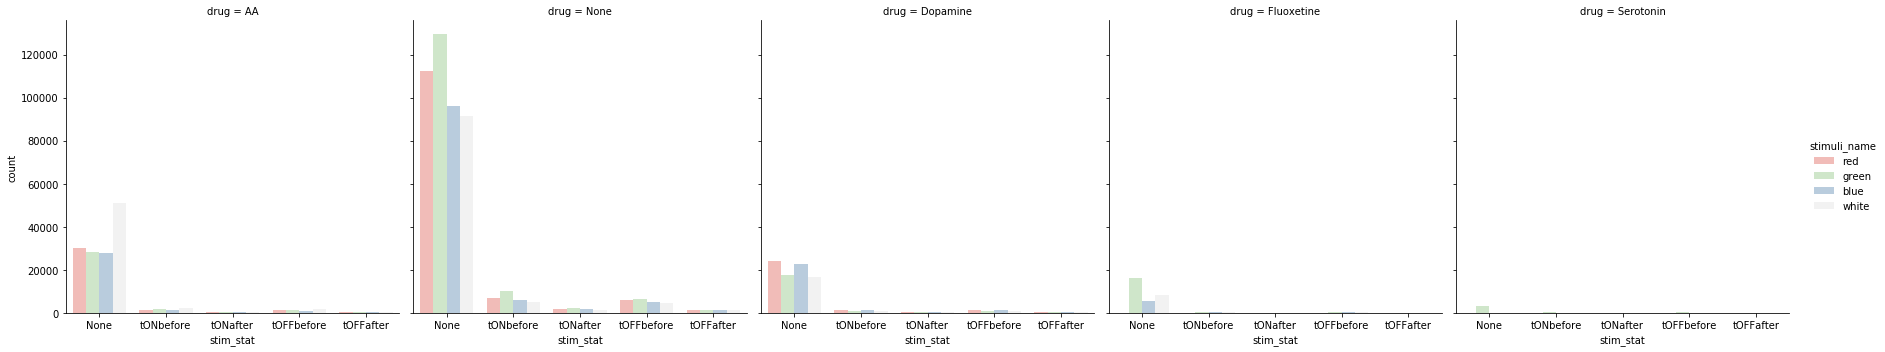

In [126]:
sns.catplot(data = df_features_light_qual, col= 'drug', x='stim_stat',  hue='stimuli_name',kind='count',
           hue_order=stim_order, palette=stim_color_order)
plt.savefig('fluoxetine_too_less_data.svg')

In [98]:
df_light = df_features_light_qual[(df_features_light_qual['stim_stat'] == 'tOFFafter')
                                   &(df_features_light_qual['stimuli_name'] == 'white')
                                 &(df_features_light_qual['drug'] == 'Fluoxetine')]

In [100]:
df_light

,frames,filename,drug,light,stimuli_name,stim_stat,curv_head,speed_x_head,speed_y_head,speed_head,...,rel_tan_tail_mid,rel_tan_tail_post_mid,rel_tan_tail_tip,ects_1,ects_2,ects_3,ects_4,ects_5,ects_6,quirkness
2715,2715,20180705_170949_1_5m0s_Fluoxetine_None_Light_s...,Fluoxetine,Light,white,tOFFafter,0.001611,-0.179749,0.476929,0.509677,...,0.298115,0.231173,0.216988,0.901149,0.327817,0.588894,0.492843,0.475276,0.295002,0.998247
2716,2716,20180705_170949_1_5m0s_Fluoxetine_None_Light_s...,Fluoxetine,Light,white,tOFFafter,0.000847,0.017761,-1.017761,1.017916,...,0.341495,0.271908,0.278396,0.901248,0.326211,0.588969,0.492727,0.474770,0.294920,0.998142
2717,2717,20180705_170949_1_5m0s_Fluoxetine_None_Light_s...,Fluoxetine,Light,white,tOFFafter,-0.004624,0.640137,0.359833,0.734340,...,0.293345,0.284826,0.273064,0.901600,0.327981,0.586823,0.492162,0.475051,0.294487,0.998238
2718,2718,20180705_170949_1_5m0s_Fluoxetine_None_Light_s...,Fluoxetine,Light,white,tOFFafter,-0.002397,-0.051758,0.051758,0.073197,...,0.377370,0.296906,0.251405,0.901546,0.328018,0.586759,0.492174,0.475216,0.294337,0.998007
2719,2719,20180705_170949_1_5m0s_Fluoxetine_None_Light_s...,Fluoxetine,Light,white,tOFFafter,-0.004723,-0.362427,0.362457,0.512570,...,0.274981,0.187214,0.266943,0.901565,0.327464,0.587064,0.492221,0.474982,0.294547,0.998272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2786,2786,20180705_170949_1_5m0s_Fluoxetine_None_Light_s...,Fluoxetine,Light,white,tOFFafter,-0.005613,-0.250610,0.250580,0.354395,...,0.341385,0.235422,0.204770,0.901594,0.330141,0.587428,0.492314,0.475853,0.295139,0.998096
2787,2787,20180705_170949_1_5m0s_Fluoxetine_None_Light_s...,Fluoxetine,Light,white,tOFFafter,-0.000885,0.166931,-0.126740,0.209592,...,0.317609,0.294164,0.330097,0.901500,0.325880,0.588414,0.492667,0.474524,0.294437,0.997698
2788,2788,20180705_170949_1_5m0s_Fluoxetine_None_Light_s...,Fluoxetine,Light,white,tOFFafter,-0.005759,-0.655334,-0.344666,0.740444,...,0.259591,0.257366,0.224860,0.902046,0.328916,0.586103,0.492120,0.475151,0.294608,0.998155
2789,2789,20180705_170949_1_5m0s_Fluoxetine_None_Light_s...,Fluoxetine,Light,white,tOFFafter,-0.002741,0.772034,0.227966,0.804987,...,0.337985,0.275356,0.292238,0.901617,0.328070,0.587126,0.492233,0.475256,0.294744,0.998082


In [89]:
for drug in ['None', 'Fluoxetine']:
 
        
    df_light = df_features_light_qual[(df_features_light_qual['stim_stat'] == 'tOFFafter')
                                       &(df_features_light_qual['stimuli_name'] == 'white')
                                     &(df_features_light_qual['drug'] == drug)]
    df_lights_qual_files = df_light.groupby(by = 'filename')
    
    df_light_qual_exps = []
    for fname in list(df_light.filename.unique()):
        df_light_qual_exps.append(df_light_qual_files.get_group(fname))
    
#     display(df_light_qual_exps[0])

    list_clusters_all = Parallel(n_jobs=20, verbose = 5)(delayed(make_binarycluster_df)(df) 
                                                for df in df_light_qual_exps)

#     print(drug, len(list_clusters_all))

    list_dfs = []
    for list_clus in list_clusters_all:

        start_list = [x for x in list_clus[:-1]]
        stop_list = [x for x in list_clus[1:]]

        trans_dict = {'start': start_list, 'stop': stop_list}
        df = pd.DataFrame(trans_dict)
        list_dfs.append(df)
    transition_df = pd.concat(list_dfs) 

    transition_counts_control = transition_df.groupby(['start', 'stop']).size().reset_index(name='counts')
    trans_mat_counts = pd.pivot_table(transition_counts_control, values='counts', index=['start'],
                    columns=['stop'])
    trans_mat_counts = trans_mat_counts.fillna(0)
    trans_mat_probs = trans_mat_counts.div(trans_mat_counts.sum(axis=1))

    display(trans_mat_probs)
    trans_mat_probs.to_pickle(f'../Data/transmat_{n_states}states_feats{n_feats}_light/transmat_{drug}_light{len(df_light_qual_exps)}_{n_states}states_{n_feats}feats.pkl')

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done   2 out of  17 | elapsed:    1.7s remaining:   12.4s
[Parallel(n_jobs=20)]: Done   6 out of  17 | elapsed:    1.7s remaining:    3.1s
[Parallel(n_jobs=20)]: Done  10 out of  17 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=20)]: Done  14 out of  17 | elapsed:    1.7s remaining:    0.4s
[Parallel(n_jobs=20)]: Done  17 out of  17 | elapsed:    1.7s finished


stop,0,1,2,3,4,5,6,7,8,9
start,,,,,,,,,,
0,0.983924,0.001164,0.010903,0.000000,0.002104,0.000000,0.000566,0.003756,0.000000,0.002926
1,0.000000,0.772842,0.179387,0.000715,0.000000,0.013463,0.038294,0.000000,0.000303,0.000180
2,0.006243,0.123472,0.751127,0.012160,0.000301,0.035901,0.003218,0.000121,0.000000,0.009049
3,0.000000,0.000097,0.002907,0.984263,0.000301,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000858,0.000582,0.000291,0.000000,0.952510,0.000748,0.000460,0.000121,0.001365,0.005177
5,0.000000,0.000388,0.006832,0.002861,0.000601,0.896784,0.000248,0.000000,0.002578,0.002566
6,0.000234,0.100679,0.017735,0.000000,0.001202,0.009723,0.954917,0.003998,0.001517,0.002341
7,0.003512,0.000194,0.000145,0.000000,0.000000,0.000000,0.000530,0.990550,0.000000,0.000675
8,0.000078,0.000485,0.000000,0.000000,0.006613,0.002244,0.000212,0.000000,0.994086,0.000090


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.8s finished


stop,1,2,4,5,6,8,9
start,,,,,,,
1,0.666667,0.0,0.000000,0.008547,0.000000,0.000000,0.000000
2,0.000000,0.5,0.000000,0.000000,0.008696,0.000000,0.000000
4,0.000000,0.0,0.864734,0.019943,0.147826,0.000312,0.002020
5,0.222222,0.5,0.019324,0.849003,0.008696,0.001559,0.035354
6,0.000000,0.0,0.009662,0.017094,0.713043,0.000312,0.023232
8,0.111111,0.0,0.004831,0.002849,0.095652,0.995636,0.014141
9,0.000000,0.0,0.101449,0.102564,0.026087,0.002338,0.924242


### HMM training 

In [ ]:
n_states = 10

In [ ]:
n_iter = n_states * 100


In [ ]:
model_control = hmm.MultinomialHMM(n_components= n_states, n_iter= n_iter, verbose= True)


In [ ]:
# model.fit(X_train, X_train_lengths)
model_control.fit(X_train_control.reshape(-1, 1), cluster_control_lens)

In [ ]:
if model_control.monitor_.converged:
    print("Model converged")

## Per drug

In [ ]:
list_clusters_drugs = Parallel(n_jobs=30, verbose = 5)(delayed(make_binarycluster_df)(df) 
                                                for df in df_drug_qual_exps)
# df_motif_drugs = pd.concat(list_df_clusters_drugs)
# fn_motif_drugs = f'../Data/clusters_dataframe_{n_train_exps}SeenDrugsQTested{len(df_drug_qual_exps)}_{n_states}model{fn_motif_tail}.pkl'

# Per light stimuli

In [ ]:
list_df_clusters_light = Parallel(n_jobs=30, verbose = 5)(delayed(make_binarycluster_df)(df) 
                                                for df in df_light_qual_exps)
# df_motif_light = pd.concat(list_df_clusters_light)
# fn_motif_light = f'../Data/clusters_dataframe_{n_train_exps}SeenLightQTested{len(df_light_qual_exps)}_{n_states}model{fn_motif_tail}.pkl'

# Checking the prediction

In [ ]:
df_motif_all_151 = pd.read_pickle('../Data/motifs_dataframe_seenControl151_10model301_normed.pkl')
df_motif_all_543 = pd.read_pickle('../Data/motifs_dataframe_seenControl543_10model301_normed.pkl')
df_motif_all = pd.read_pickle('../Data/motifs_dataframe_seenControl694_10model301_normed.pkl')

In [ ]:
fig1, axes = plt.subplots(1,3, figsize=(24,8))
sns.countplot(data=df_motif_all_151, x='cluster',ax=axes[0])
sns.countplot(data=df_motif_all_543, x='cluster',ax=axes[1])
sns.countplot(data=df_motif_all, x='cluster',ax=axes[2])
axes[0].set_title('Motif count in 151 experiments' , y=-0.21)
axes[1].set_title('Motif count in 543 experiments' , y=-0.21)
axes[2].set_title('Motif count in all 694 experiments' , y=-0.21)
# plt.suptitle('Comparison of number of motifs in clusters  n_states=12')
# fig1.savefig(f'../Results/predict_Seen694_model694_results/countplot_clus12_694exps_model694normed.png')
plt.tight_layout()

In [ ]:
fig2, axes = plt.subplots(1,3, figsize=(24,8))


sns.barplot(x="cluster", y= "cluster", data=df_motif_all_151, estimator=lambda x: len(x) / len(df_motif_all_151) * 100, ax=axes[0])
sns.barplot(x="cluster", y= "cluster",data=df_motif_all_543, estimator=lambda x: len(x) / len(df_motif_all_543) * 100, ax=axes[1])
sns.barplot(x="cluster", y= "cluster",data=df_motif_all, estimator=lambda x: len(x) / len(df_motif_all) * 100, ax=axes[2])

axes[0].set_title('Motif count in 151 experiments', y=-0.21)
axes[1].set_title('Motif count in 543 experiments', y=-0.21)
axes[2].set_title('Motif count in all 694 experiments', y=-0.21)
plt.suptitle('Comparison of percentage of motifs in clusters : model 694 normed n_states = 12')


for ax in axes:
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.2f}'.format(y), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
# fig2.savefig(f'../Results/predict_Seen694_model694_results/percentplot_clus12_694exps_model694normed.png')

In [ ]:
c_pal = sns.color_palette("tab10", 10)

In [ ]:
example_files = random.sample(list(df_motif_all_151['filename'].unique()), 25)
len(example_files)

In [ ]:
df_motif_grouped_files = df_motif_all_151.groupby('filename')

In [ ]:
data_folder = '/share/data/temp/athira/Tierpsy_skeleton_files_July13/'

In [ ]:
fig, axes = plt.subplots(5,5, figsize = (50,50), dpi=200, sharex=True, sharey=True)

axs = axes.flatten()
for i in range(25):
    
    fn = example_files[i]
    df_exp_motifs = df_motif_grouped_files.get_group(fn)
#     df_exp_motifs.sort_values(by='start', inplace=True)
    
    fn_parts = fn.split('_')
    
    fpath = os.path.join(data_folder, fn)
    skel_obj = h5py.File(fpath, 'r')
    skel_array = np.array(skel_obj['skeleton'])
    skel_array = del_nan_rows(skel_array)
    
        
    color_list = np.zeros((skel_array.shape[0],))
    for index, row in df_exp_motifs.iterrows():
        cl = int(row['cluster'])
        for j in range(int(row['start']),int(row['stop'])+1):
            color_list[j] = cl
            
    color_list1 = [c_pal[int(k)] for k in list(color_list)]
    try:
        axs[i].scatter(skel_array[:,12,0],skel_array[:,12,1], c=color_list1, s=0.1)
    except ValueError:
        print('mismatch number of frames')
    finally:
        axs[i].set_title(f'{fn_parts[0]}_{fn_parts[1]}_{fn_parts[2]}')
        
# fig.savefig('../Results/predict_Seen694_model694_results/path_100_clus12_151exps_12model694normed.svg')
# fig.savefig('../Results/predict_Seen694_model694_results/path_100_clus12_151exps_12model694normed.png')

### Plots gifs

In [ ]:
def rotate(x, y, angle):
    xr = x*np.cos(angle) - y* np.sin(angle)
    yr = x*np.sin(angle) + y* np.cos(angle)
    return xr,yr
def get_base_angle(x,y, degrees = False):
    angle = np.arctan(y/x)
    if y < 0:
        angle *=-1
    if not degrees:
        return(angle)
    else:
        return(np.degrees(angle))

In [ ]:
fig_hist, axes = plt.subplots(n_states,1, figsize = (8,n_states*2))
axs = axes.flatten()
for i in range(n_states):
    try:
        df_motif_all[df_motif_all['cluster']==i]['duration'].hist(ax=axs[i])
        max_dur = df_motif_all[df_motif_all['cluster']==i]['duration'].max()
        axs[i].set_title(f'clus {i}_max {int(max_dur)}')
    except ValueError:
        print(f'{i} Value error')

plt.tight_layout()

In [ ]:
n_files = 25
motifs_filter_duration = df_motif_all[(df_motif_all['duration']>=15)&((df_motif_all['duration']<=200))]
# motifs_filter_duration = df_motif_all[(df_motif_all['duration']>=5)]
sample_motifs = motifs_filter_duration.groupby(by='cluster').sample(n_files)
groups = sample_motifs.groupby(by='cluster')

In [ ]:
# import matplotlib.animation as man_an
# Writer = man_an.writers['imagemagick']
# writer = Writer(metadata=dict(artist='Me'))

In [ ]:
n_states= 10
data_folder = '/share/data/temp/athira/Tierpsy_skeleton_files_July13/'

In [ ]:
for cluster in tqdm.tqdm(np.arange(n_states)):
    
    def animate(i):
        for j, m in enumerate(selected_motifs_1):
#             if i%30 == 0:
#                 axes.ravel()[j].clear()
            frame = m[i,:,:]
            xs = frame[:,0]
            ys = frame[:,1]
            angle = get_base_angle(xs[12], ys[12]) - np.pi
            xs = xs-frame[12, 0]
            ys = ys-frame[12, 1]
            xs, ys = rotate(xs, ys, angle)
            axes.ravel()[j].plot(xs, ys, c = c_pal[cluster], alpha = 0.4)
            axes.ravel()[j].axis("off")
#             axes.ravel()[j].set_title(f'{len(m)}')
        plt.suptitle(f'Motifs from Cluster {cluster}')
        
        
    selected_motifs_1 = []
    
    try:
        motifs = groups.get_group(cluster)

        for i in range(25):
            motif = motifs.iloc[i]

            fname = motif['filename']
            fpath = os.path.join(data_folder, fname)

            skel_obj = h5py.File(fpath, 'r')
            skel_array = np.array(skel_obj['skeleton'])
            skel_array = del_nan_rows(skel_array)

            start = int(motif['start'])
            stop = int(motif['stop'])

            selected_motifs_1.append(skel_array[start:stop,:,:])

        fig, axes = plt.subplots(15,15, figsize = (10,10))

        anim = animation(fig, animate, frames = 15, interval = 200).save(f'../Results/predict_Seen694_model694_results/aligned_gifs_Seen694_model8normed694_tryabove30/clus{cluster}.gif', writer='imagemagick')
    #     display(HTML(anim))

In [ ]:
motifs = groups.get_group(6)

In [ ]:
@widgets.interact_manual
def animate_cluster(cluster=range(n_states)):
    
    def animate(i):
        for j, m in enumerate(selected_motifs_1):
#             if i%30 == 0:
#                 axes.ravel()[j].clear()
            frame = m[i,:,:]
            xs = frame[:,0]
            ys = frame[:,1]
            angle = get_base_angle(xs[12], ys[12]) - np.pi
            xs = xs-frame[12, 0]
            ys = ys-frame[12, 1]
            xs, ys = rotate(xs, ys, angle)
            axes.ravel()[j].plot(xs, ys, c = c_pal[cluster], alpha = 0.4)
            axes.ravel()[j].axis("off")
#             axes.ravel()[j].set_title(f'{len(m)}')
        plt.suptitle(f'Motifs from Cluster {cluster}')
        
        
    selected_motifs_1 = []
    motifs = groups.get_group(cluster)

    for i in range(25):
        motif = motifs.iloc[i]

        fname = motif['filename']
        fpath = os.path.join(data_folder, fname)

        skel_obj = h5py.File(fpath, 'r')
        skel_array = np.array(skel_obj['skeleton'])
        skel_array = del_nan_rows(skel_array)

        start = int(motif['start'])
        stop = int(motif['stop'])

        selected_motifs_1.append(skel_array[start:stop,:,:])
        
    fig, axes = plt.subplots(5,5, figsize = (10,10))
    
    anim = animation(fig, animate, frames = 15, interval = 200).to_jshtml()#.save(f'../Results/predict_testControlSeen_model694_results/unaligned_gifs_testControlSeen_model694_/clus{cluster}.gif', writer='imagemagick')
    display(HTML(anim))

In [ ]:
motifs_filter_duration = df_motif_all[(df_motif_all['duration']>=15)]
sample_motifs = motifs_filter_duration.groupby(by='cluster').sample(25)
groups = sample_motifs.groupby(by='cluster')

In [ ]:
@widgets.interact_manual
def animate_cluster(cluster=range(n_states)):
    
    def animate(i):
        
        
        for j, m in enumerate(selected_motifs_2):
            try:
                frame = m[i,:,:]
                xs = frame[:,0]
                ys = frame[:,1]
        #             angle = get_base_angle(xs[12], ys[12]) - np.pi
        #             xs = xs-frame[12, 0]
        #             ys = ys-frame[12, 1]
        #             xs, ys = rotate(xs, ys, angle)
                axes.ravel()[j].plot(xs, ys, c = c_pal[cluster], alpha = 0.4)
            
            except IndexError:
                pass
            finally:
                axes.ravel()[j].axis("off")
                axes.ravel()[j].set_title(f'dur {len(m)}')
        
        plt.suptitle(f'Motifs from Cluster {cluster}')
        
    selected_motifs_2 = []
    motifs = groups.get_group(cluster)

    for i in range(15):
        motif = motifs.iloc[i]

        fname = motif['filename']
        fpath = os.path.join(data_folder, fname)

        skel_obj = h5py.File(fpath, 'r')
        skel_array = np.array(skel_obj['skeleton'])
        skel_array = del_nan_rows(skel_array)

        start = int(motif['start'])
        stop = int(motif['stop'])

        selected_motifs_2.append(skel_array[start:stop,:,:])
        
    fig, axes = plt.subplots(2,15, figsize = (30,6))
    for k in range(15,30):
        axes.ravel()[k].scatter(selected_motifs_2[k-15][:,:,0],selected_motifs_2[k-15][:,:,1], s=0.1)
        axes.ravel()[k].axis('off')
    anim = animation(fig, animate, frames = 90, interval = 100).to_jshtml()#.save(f'../Results/aligned_gifs_testControlUnseen543/clus{cluster}.gif', writer='imagemagick')
    display(HTML(anim))

# Predict dataset 2 : Unseen drug data

In [ ]:
n_states = 8 
data_folder = '/share/data/temp/athira/Tierpsy_skeleton_files_July13/'

In [ ]:
def make_cluster_df_drug(df):    
    
    clusters = model.predict(df.filter(items = feats_list).values)
    
    fname = df.filename.unique()[0]
    fpath = os.path.join(data_folder, fname)
    
    skel_obj = h5py.File(fpath, 'r')
    skel_array = np.array(skel_obj['skeleton'])
    skel_array = del_nan_rows(skel_array)
    
    df_motif = []
    
    for state in range(n_states):
        
        clus = {}
        clus_inds = [ind for ind, val in enumerate(clusters) if val == state]
        clus_inds_nested = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(clus_inds), lambda x: x[0]-x[1])]
        clus['start'] = [x[0] for x in clus_inds_nested]
        clus['stop'] = [x[-1] for x in clus_inds_nested]
        clus['duration'] = [x[-1]-x[0] for x in clus_inds_nested]
        clus['cluster'] = [state for x in clus_inds_nested]
        clus['filename'] = [fname for x in clus_inds_nested]
        clus['drug'] = [fname.split('_')[4] for x in clus_inds_nested]
        df_clus = pd.DataFrame(clus)
        
        df_motif.append(df_clus)
     
    df_motif = pd.concat(df_motif)   
    return df_motif
        
    

In [ ]:
# df_motif_control_all_wl = df_motif_control_all
# # df_motif_control_all_wl['light'] = 'None'
# df_motif_drug_all_wl = df_motif_drugs_899
# # df_motif_light_all_wl['light'] = 'Light'

In [ ]:
df_drugs_and_control = pd.concat([df_motif_control_all, df_motif_drugs_899])

In [ ]:
df_drugs_and_control['cluster'] = df_drugs_and_control['cluster'].astype(int)

In [ ]:
df_drugs_and_control['active'] = df_drugs_and_control['cluster'].apply(lambda x: True if x in [1,2,6,9] else False) 

In [ ]:
df_drugs_and_control = df_drugs_and_control[(df_drugs_and_control['cluster'] == 1) | 
                                           (df_drugs_and_control['cluster'] == 2) |
                                           (df_drugs_and_control['cluster'] == 6) |
                                           (df_drugs_and_control['cluster'] == 9)]

In [ ]:
df_durations_per_and_cluster = df_drugs_and_control.groupby(['drug','cluster'])[['duration']].sum()

In [ ]:
df_durs = df_durations_per_and_cluster.groupby(['drug']).apply(lambda x:100 * x / float(x.sum())).reset_index()

In [ ]:
df_durs

In [ ]:
pivoted_df = df_durs.pivot(index = 'drug', columns='cluster', values = 'duration')

In [ ]:
pivoted_df

In [ ]:
pivoted_df.to_csv(f'{save_folder}/panel_e/drug_percent_clusters_ref.csv')

In [ ]:
# drugs_sorted = sorted(list(df_motif_drugs_899.drug.unique()))

In [ ]:
# drugs_sorted

In [ ]:
# drugs_sorted.append('None')
# print(drugs_sorted)

In [ ]:
# pivoted_df.sort_values(by='drug', key= drugs_sorted)

In [ ]:
fig2, axes = plt.subplots(1,1, figsize=(12,5))
pivoted_df.plot(kind='bar',stacked='True', ax=axes, legend=False, color = colors)
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45, ha="right")
# axes.set_xticklabels(drug_order, rotation = 45, ha="right")

plt.gcf().subplots_adjust(bottom=0.25)
plt.legend(loc="upper center", bbox_to_anchor=(1.03,1))
fig2.savefig(f'{save_folder}/panel_e/drug_percent_clusters.svg')
# for i, p in enumerate(axes.patches):
#     if i < 18:
#         vert = -10

#         axes.annotate(format(p.get_height(), '.0f'), 
#                        (p.get_x() + p.get_width() / 2., p.get_height()), 
#                        ha = 'center', va = 'center', 
#                        xytext = (0, vert), 
#                        textcoords = 'offset points')

In [ ]:

fig3 = sns.clustermap(pivoted_df.T, row_cluster=False)
# fig3.savefig(f'{save_folder}/light_clustermap.png')

In [ ]:
# sns.set_palette("tab10", 8)

In [ ]:
# df_drugs_motif_all.to_pickle('../Data/motifs_dataframe_unseenDrugsQTested899.pkl')

In [ ]:
n_files = 25
motifs_filter_duration_drugs = df_drugs_motif_all[(df_drugs_motif_all['duration']>=30)&((df_drugs_motif_all['duration']<=100))]
sample_motifs_drugs = motifs_filter_duration_drugs.groupby(by='cluster').sample(n_files, replace= True)
groups_drugs = sample_motifs_drugs.groupby(by='cluster')

In [ ]:
@widgets.interact_manual
def animate_cluster(cluster=[0,1,2,3,4,5,6,7]):
    
    def animate(i):
        for j, m in enumerate(selected_motifs_1):
#             if i%30 == 0:
#                 axes.ravel()[j].clear()
            frame = m[i,:,:]
            xs = frame[:,0]
            ys = frame[:,1]
            angle = get_base_angle(xs[12], ys[12]) - np.pi
            xs = xs-frame[12, 0]
            ys = ys-frame[12, 1]
            xs, ys = rotate(xs, ys, angle)
            axes.ravel()[j].plot(xs, ys, c = c_pal[cluster], alpha = 0.4)
            axes.ravel()[j].axis("off")
            axes.ravel()[j].set_title(f'{len(m)} {drugs_motifs_1[j]}')
        plt.suptitle(f'Motifs from Cluster {cluster}')
        
        
    selected_motifs_1 = []
    drugs_motifs_1 = []
    motifs = groups_drugs.get_group(cluster)

    for i in range(25):
        motif = motifs.iloc[i]

        fname = motif['filename']
        drugs_motifs_1.append(fname.split('_')[4])
        fpath = os.path.join(data_folder, fname)

        skel_obj = h5py.File(fpath, 'r')
        skel_array = np.array(skel_obj['skeleton'])
        skel_array = del_nan_rows(skel_array)

        start = int(motif['start'])
        stop = int(motif['stop'])

        selected_motifs_1.append(skel_array[start:stop,:,:])
        
    fig, axes = plt.subplots(5,5, figsize = (10,10))
    
    anim = animation(fig, animate, frames = 30, interval = 100).save(f'../Results/predict_testDrugsUnseen899_results/aligned_gifs_testControlUnseen899/clus{cluster}.gif', writer='imagemagick')
#     display(HTML(anim))

In [ ]:
example_files_drugs_test = random.sample(list(df_motif_control_all['filename'].unique()), 4)
len(example_files_drugs_test)

In [ ]:
set1 = ['20180808_122216_1_15m0s_None_None_None_skeletons.hdf5', '20180725_102308_1_15m0s_None_None_None_skeletons.hdf5', '20180727_120042_1_5m0s_None_None_None_skeletons.hdf5', '20180823_100828_1_15m0s_None_None_None_skeletons.hdf5']

set2 = ['20180725_150813_1_5m0s_None_None_None_skeletons.hdf5', '20180823_151523_1_15m0s_None_None_None_skeletons.hdf5', '20180817_131951_1_5m0s_None_None_None_skeletons.hdf5', '20180727_170709_1_5m0s_None_None_None_skeletons.hdf5']

set3 = ['20180717_112643_1_5m0s_None_None_None_skeletons.hdf5', '20180808_114234_1_15m0s_None_None_None_skeletons.hdf5', '20180725_150813_1_5m0s_None_None_None_skeletons.hdf5', '20180808_115805_1_15m0s_None_None_None_skeletons.hdf5']

In [ ]:
df_features = pd.read_pickle('/share/data/temp/athira/July17_features_combined_noLightStimuli.pickle')

In [ ]:
df_files = df_features.groupby('filename')

In [ ]:
# fig, axs = plt.subplots(4,1, figsize = (40,10))
# df_motif_grouped_files_drugs = df_motif_control_all.groupby('filename')
# i = 0
# fn = set1[1]
# df_exp_motifs = df_motif_grouped_files_drugs.get_group(fn)
# df_exp_feats = df_files.get_group(fn)
# fpath = os.path.join(data_folder, fn)
# skel_obj = h5py.File(fpath, 'r')
# skel_array = np.array(skel_obj['skeleton'])
# print(calc_quality(skel_array))
# print(fn, df_exp.shape, df_exp_motifs.shape)

# skel_array = del_nan_rows(skel_array)
# cluster = []
# for index, row in df_exp_motifs.iterrows():
#     cl = int(row['cluster'])
#     for j in range(int(row['start']),int(row['stop'])+1):
#         cluster[j] = cl
        
#     t_axis = np.arange(int(row['start']),int(row['stop']))
#     axs[i].plot(t_axis, curv[int(row['start']):int(row['stop']),12], c= colors[cl])
#     axs[i+1].plot(t_axis, curv[int(row['start']):int(row['stop']),12], c= colors[cl])
#     axs[i+2].plot(t_axis, curv[int(row['start']):int(row['stop']),12], c= colors[cl])
#     axs[i+3].plot(t_axis, curv[int(row['start']):int(row['stop']),12], c= colors[cl])
    
    
# # color_list1 = [colors[int(k)] for k in list(color_list)]
# # print(len(color_list1), skel_array.shape, curv.shape)
# # try:
# #     axs[i].scatter(skel_array[:,12,0],skel_array[:,12,1], c=color_list1, s=1)
# #     time_axis = np.arange(0,skel_array.shape[0])
# #     print(time_axis.shape)
# #     axs[i+1].scatter(time_axis,curv[:,12], c=color_list1, s=1)
# # except ValueError:
# #     print('mismatch number of frames')
# # finally:
# #     axs[i].set_title(f'{fn_parts[0]}_{fn_parts[1]}_{fn_parts[2]}')

In [ ]:
fig, axs = plt.subplots(1,1, figsize = (40,15))
axs = [axs]
df_motif_grouped_files_drugs = df_motif_control_all.groupby('filename')
i = 0
fn = set1[1]
df_exp_motifs = df_motif_grouped_files_drugs.get_group(fn)
df_exp_feats = df_files.get_group(fn)
fpath = os.path.join(data_folder, fn)
skel_obj = h5py.File(fpath, 'r')
skel_array = np.array(skel_obj['skeleton'])
print(calc_quality(skel_array))
print(fn, df_exp_feats.shape, df_exp_motifs.shape, skel_array.shape)
# skel_array = del_nan_rows(skel_array)
skel_array = skel_array[df_exp_feats.frames]

print(fn, df_exp_feats.shape, df_exp_motifs.shape, skel_array.shape)

curv = df_exp_feats['curv_neck'].values
speed = df_exp_feats['speed_neck'].values
ects = df_exp_feats['ects_1'].values

color_list = np.zeros((skel_array.shape[0],))
for index, row in df_exp_motifs.iterrows():
    cl = int(row['cluster'])
    for j in range(int(row['start']),int(row['stop'])+1):
        color_list[j] = cl
    t_axis = np.arange(int(row['start']),int(row['stop'])+1)
    
    
    axs[i].plot(t_axis, (9 + 50* curv[int(row['start']):int(row['stop'])+1]), c= colors[cl])
time_axis = np.arange(0,skel_array.shape[0])
axs[i].plot(time_axis, 1 + (color_list == 6), c=colors[6])
axs[i].fill_between(x = time_axis, y1 = 1 + (color_list == 6), y2 = (len(color_list))*[1], color=colors[6])

axs[i].plot(time_axis, 3 + (color_list == 3), c=colors[3])
axs[i].fill_between(x = time_axis, y1 = 3 + (color_list == 3), y2 = (len(color_list))*[3], color=colors[3])

axs[i].plot(time_axis, 5 + (color_list == 7), c=colors[7])
axs[i].fill_between(x = time_axis, y1 = 5 + (color_list == 7), y2 = (len(color_list))*[5], color=colors[7])


In [ ]:
fig, axs = plt.subplots(1,1, figsize = (40,20))
axs = [axs]
df_motif_grouped_files_drugs = df_motif_control_all.groupby('filename')
i = 0
fn = set1[1]
df_exp_motifs = df_motif_grouped_files_drugs.get_group(fn)
df_exp_feats = df_files.get_group(fn)
fpath = os.path.join(data_folder, fn)
skel_obj = h5py.File(fpath, 'r')
skel_array = np.array(skel_obj['skeleton'])
print(calc_quality(skel_array))
print(fn, df_exp_feats.shape, df_exp_motifs.shape, skel_array.shape)
# skel_array = del_nan_rows(skel_array)
skel_array = skel_array[df_exp_feats.frames]

print(fn, df_exp_feats.shape, df_exp_motifs.shape, skel_array.shape)

curv = df_exp_feats['curv_neck'].values
speed = df_exp_feats['speed_neck'].values
ects = df_exp_feats['ects_1'].values

color_list = np.zeros((skel_array.shape[0],))
for index, row in df_exp_motifs.iterrows():
    cl = int(row['cluster'])
    for j in range(int(row['start']),int(row['stop'])+1):
        color_list[j] = cl
    t_axis = np.arange(int(row['start']),int(row['stop'])+1) /30
    
    
    axs[i].plot(t_axis, (20 + 50* curv[int(row['start']):int(row['stop'])+1]), c= colors[cl])
    
    
time_axis = np.arange(0,skel_array.shape[0]) /30

for clus in range(10):
    gap = 0.5 * clus
    axs[i].plot(time_axis, clus + gap + (color_list == clus), c=colors[clus], label = f'{clus}')
    axs[i].fill_between(x = time_axis, y1 = clus + gap + (color_list == clus), y2 = (len(color_list))*[clus + gap], color=colors[clus])
# leg = plt.legend(title = 'states', fontsize = 'x-large', markerscale = 30)
axs[i].set_xlabel('Time in seconds', size = 'xx-large')
axs[i].set_yticklabels('')
# # axs[i].get_legend().remove()
# for line in leg.get_lines():
#     line.set_linewidth(4.0)
    
fig.savefig(f'{save_folder}/panel_a/all_in_one.png')

In [ ]:
fig, axs = plt.subplots(2,1, figsize = (40,20))

df_motif_grouped_files_drugs = df_motif_control_all.groupby('filename')
i = 0
fn = set1[1]
df_exp_motifs = df_motif_grouped_files_drugs.get_group(fn)
df_exp_feats = df_files.get_group(fn)
fpath = os.path.join(data_folder, fn)
skel_obj = h5py.File(fpath, 'r')
skel_array = np.array(skel_obj['skeleton'])
print(calc_quality(skel_array))
print(fn, df_exp_feats.shape, df_exp_motifs.shape, skel_array.shape)
# skel_array = del_nan_rows(skel_array)
skel_array = skel_array[df_exp_feats.frames]

print(fn, df_exp_feats.shape, df_exp_motifs.shape, skel_array.shape)

curv = df_exp_feats['curv_neck'].values
speed = df_exp_feats['speed_neck'].values
ects = df_exp_feats['ects_1'].values

color_list = np.zeros((skel_array.shape[0],))
for index, row in df_exp_motifs.iterrows():
    cl = int(row['cluster'])
    for j in range(int(row['start']),int(row['stop'])+1):
        color_list[j] = cl
    t_axis = np.arange(int(row['start']),int(row['stop'])+1) /30
    
    
    axs[i].plot(t_axis, (20 + 50* curv[int(row['start']):int(row['stop'])+1]), c= colors[cl])
    
axs[i].set_xlabel('Time in seconds', size = 'xx-large')
axs[i].set_ylabel('Curvature (neck segment)', size = 'xx-large')

time_axis = np.arange(0,skel_array.shape[0]) /30

for clus in range(10):
    gap = 0.5 * clus
    axs[i+1].plot(time_axis, clus + gap + (color_list == clus), c=colors[clus], label = f'{clus}')
    axs[i+1].fill_between(x = time_axis, y1 = clus + gap + (color_list == clus), y2 = (len(color_list))*[clus + gap], color=colors[clus])
leg = plt.legend(title = 'states', fontsize = 'xx-large', markerscale = 30)
axs[i+1].set_xlabel('Time in seconds', size = 'xx-large')
axs[i+1].set_yticklabels('')
axs[i+1].set_ylabel('HMM states', size = 'xx-large')
for line in leg.get_lines():
    line.set_linewidth(4.0)
    
fig.savefig(f'{save_folder}/panel_a/split.svg')

In [ ]:
path_metadata = '/share/data/longterm/10/athira/paper_tierpsy_behavior_v0/metadata/20210209_metadata_1743_of_4086_exps.pickle'
df_metadata = pd.read_pickle(path_metadata)
# df_metadata.columns
df_100percent = df_metadata[(df_metadata['good_694'] == True) | (df_metadata['quality'] == 100)]

In [ ]:
save_folder

In [ ]:
df_100percent.filename.values

In [ ]:
# fig, axes = plt.subplots(10,10, figsize = (50,50), dpi=100, sharex=True, sharey=True)
# df_motif_grouped_files_drugs = df_drugs_motif_all.groupby('filename')
# axs = axes.flatten()
# for i in range(100):
    
#     fn = example_files_drugs_test[i]
#     df_exp_motifs = df_motif_grouped_files_drugs.get_group(fn)
# #     df_exp_motifs.sort_values(by='start', inplace=True)
    
#     fn_parts = fn.split('_')
    
#     fpath = os.path.join(data_folder, fn)
#     skel_obj = h5py.File(fpath, 'r')
#     skel_array = np.array(skel_obj['skeleton'])
#     skel_array = del_nan_rows(skel_array)
    
        
#     color_list = np.zeros((skel_array.shape[0],))
#     for index, row in df_exp_motifs.iterrows():
#         cl = int(row['cluster'])
#         for j in range(int(row['start']),int(row['stop'])+1):
#             color_list[j] = cl
            
#     color_list1 = [c_pal[int(k)] for k in list(color_list)]
#     try:
#         axs[i].scatter(skel_array[:,12,0],skel_array[:,12,1], c=color_list1, s=1)
#     except ValueError:
#         print('mismatch number of frames')
#     finally:
#         axs[i].set_title(f'{fn_parts[0]}_{fn_parts[1]}_{fn_parts[2]}')
        
# fig.savefig('../Results/path_100_clus8_test_drugs.svg')
# fig.savefig('../Results/path_100_clus8_test_drugs.png')

In [ ]:
## 

In [ ]:
df

# Inspecting the model

### Saved feats and filenames using in training these model as additional attributes

In [ ]:
# model_fnames = [file for file in os.listdir('./') if 'hmm_states' in file]
# model_fnames

In [ ]:
# df_694 = pd.read_pickle('../Data/selected_694exps_for_hmm.pkl')
# df_151 = pd.read_pickle('../Data/selected_151exps_for_hmm.pkl')
# df_301 = pd.read_pickle('../Data/selected_301exps_for_hmm.pkl')

In [ ]:
# fnames_694 = list(df_694.filename.unique())
# fnames_151 = list(df_151.filename.unique())
# fnames_301 = list(df_301.filename.unique())

In [ ]:
# for model_fn in model_fnames:

#     with open(model_fn, "rb") as file: 
        
#         model = pickle.load(file)
        
#         if '_7feats' in model_fn:
#             model.feats = ['ects_1','ects_2','ects_3','ects_4','ects_5','ects_6','quirkness']
#         else :
#             model.feats = ['ects_1','ects_2','ects_3','ects_4','ects_5','ects_6',
#              'speed_x_neck', 'speed_y_neck','speed_x_tail_mid', 'speed_y_tail_mid','quirkness']
            
#         if '694'in model_fn:
#             model.fnames = fnames_694
#         elif '151' in model_fn:
#             model.fnames = fnames_151
#         elif '301' in model_fn:
#             model.fnames = fnames_301
#         else:
#             model.fnames = fnames_151
                
    
#     with open(model_fn, "wb") as file: pickle.dump(model, file)

In [ ]:
# model_fn = "hmm_states10_niter1000_covfull_301_normed.pkl"
# with open(model_fn, "rb") as file: 

#     model = pickle.load(file)


#     model.feats = ['ects_1','ects_2','ects_3','ects_4','ects_5','ects_6',
#          'speed_neck', 'speed_tail_mid', 'speed_tail_pre_mid','speed_tail_post_mid','quirkness']


# with open(model_fn, "wb") as file: pickle.dump(model, file)

#### Inspect the model

In [ ]:
with open("hmm_states12_niter2400_covfull_1743_11feats_normed.pkl", "rb") as file: 
    model = pickle.load(file)

In [ ]:
feats_list = model.feats

In [ ]:
feats_list

In [ ]:
fig1, axes = plt.subplots(model.n_components,1, figsize = (5,60))
for i in range(model.n_components):
    df_cov = pd.DataFrame(model.covars_[i,:,:], columns=feats_list, index=feats_list)
    sns.heatmap(df_cov, ax = axes[i])
    axes[i].set_title(f'cluster {i}')
for ax in axes:
    ax.axis('equal')
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(2,6,figsize=(18,8))
axs = axes.flatten()
for i, clus_cov in enumerate(model.covars_):
    sns.heatmap(clus_cov, ax=axs[i])
    axs[i].axis('equal')
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(7,1,figsize=(10,15))
for i in range(7):
    standard_dev = model.covars_[:,i,i]
    axes[i].plot(model.means_[:,i], 'o')
    axes[i].plot(model.means_[:,i], '-')
    axes[i].set_title(feats_list[i])
    axes[i].fill_between(range(10), model.means_[:,i]- 3*standard_dev, 
                            model.means_[:,i]+ 3*standard_dev, alpha = 0.5)
    axes[i].set_xlabel('cluster')
    axes[i].set_xticks([0,1,2,3,4,5,6,7,8,9])
    fig.savefig(f'{save_folder}/panel_d/hmm_model_means_and_std.svg')

plt.tight_layout()    

In [ ]:
# fig, axes = plt.subplots(7,1,figsize=(8,15))
# for i in range(7):
#     standard_dev = model.covars_[:,i,i]
#     x = model.means_[:,i]
#     axes[i].errorbar(x = range(x.shape[0]), y = model.means_[:,i], yerr = 3*standard_dev, 
#                      fmt='H', capsize = 2)
    
    
#     axes[i].set_title(feats_list[i])
    
#     axes[i].set_xlabel('cluster')
#     axes[i].set_xticks([0,1,2,3,4,5,6,7,8,9])
#     fig.savefig(f'{save_folder}/panel_d/hmm_model_means_and_std_test.svg')

# plt.tight_layout()    

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.heatmap(model.transmat_, cmap = 'RdBu', ax=axes[0])
# sns.heatmap(model_all.transmat_, cmap = 'RdBu', ax=axes[1])

In [ ]:
scaler_means = MinMaxScaler()
scaled_means = scaler_means.fit_transform(model.means_)

In [ ]:
df_scaled_means = pd.DataFrame(scaled_means, columns=feats_list)

In [ ]:
sns.clustermap(df_scaled_means, cmap='jet',linewidths=1, row_cluster=True, col_cluster=False)

# Subclustering or finding transmat for subclasses